# 1. Introdução

## 1.1. ENEM

De acordo com o [site do INEP](https://www.gov.br/inep/pt-br/areas-de-atuacao/avaliacao-e-exames-educacionais/enem) (Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira), o ENEM (Exame Nacional do Ensino Médio) tem como objetivo avaliar o desempenho escolar dos estudantes ao término da educação básica. Em 2009, o exame aperfeiçoou sua metodologia e passou a ser utilizado como mecanismo de acesso à educação superior.

As notas do ENEM podem ser usadas para acesso ao Sistema de Seleção Unificada (SISU) e ao Programa Universidade para Todos (ProUni). Além disso, os participantes do ENEM podem pleitear financiamento estudantil em programas do governo, como o Fundo de Financiamento Estudantil (FIES). Os resultados do ENEM possibilitam, ainda, o desenvolvimento de estudos e indicadores educacionais.

Qualquer pessoa que já concluiu o Ensino Médio ou está concluindo a etapa pode fazer o ENEM para acesso à educação superior. Os participantes que ainda não concluíram o Ensino Médio podem participar como “treineiros” e seus resultados no exame servem somente para autoavaliação de conhecimentos.

A aplicação do ENEM ocorre em dois dias. Os participantes fazem provas de quatro áreas do conhecimento: Ciências da Natureza, Ciências Humanas, Linguagens e Códigos, e Matemática, somando 180 questões objetivas. Os participantes também são avaliados por meio de uma Redação, que exige o desenvolvimento de um texto dissertativo-argumentativo a partir de uma situação-problema.

## 1.2. Objetivos deste projeto

Esse projeto tem como objetivo analisar os [microdados do ENEM](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem) realizado em 2021, a fim de extrair *insights* acerca da educação brasileira e implementar um modelo de *Machine Learning* para prever a nota dos candidatos.

Os microdados são o menor nível de desagregação de dados recolhidos por meio do exame. Eles atendem a demanda por informações específicas ao disponibilizar as provas, os gabaritos, as informações sobre os itens, as notas e o questionário respondido pelos inscritos no ENEM.

Nesse projeto, optou-se por avaliar apenas os participantes não-treineiros que concluíram todas as provas do exame e que não tiveram problemas com a Redação.

# 2. Importação das bibliotecas e configurações gerais

In [1]:
# Importando as bibliotecas

import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from skopt import gp_minimize
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Verificando a versão das bilbiotecas utilizadas

print('Versão das bibliotecas utilizadas: \n')
print('Python', sys.version.split()[0])
print('Pandas ', pd.__version__)
print('Numpy ', np.__version__)
print('Matplotlib ', matplotlib.__version__)
print('Seaborn ', sns.__version__)

Versão das bibliotecas utilizadas: 

Python 3.9.12
Pandas  1.4.2
Numpy  1.21.5
Matplotlib  3.5.2
Seaborn  0.11.2


In [3]:
# Configurando a opção para visualizar todas as colunas do DataFrame

pd.set_option('display.max_columns', None)

# 3. Coleta e tratamento dos dados

In [4]:
# Carregando parcialmente o dataset, a fim de reduzir o custo computacional das análises

df = pd.read_csv('DADOS/MICRODADOS_ENEM_2021.csv',
                 sep=';',
                 usecols=['NU_INSCRICAO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025'],
                 encoding='ISO-8859-1')

In [5]:
# Filtrando o DataFrame para considerar apenas os indivíduos que:
# - Não eram treineiros
# - Concluíram todas as provas do exame
# - Não tiveram problemas com a Redação do exame

df_filtrado = df[(df['IN_TREINEIRO'] == 0) & (df['TP_PRESENCA_CN'] == 1) & (df['TP_PRESENCA_CH'] == 1) & (df['TP_PRESENCA_LC'] == 1) & (df['TP_PRESENCA_MT'] == 1) & (df['TP_STATUS_REDACAO'] == 1)].reset_index(drop=True)

In [6]:
# Visualizando o formato das features

df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822541 entries, 0 to 1822540
Data columns (total 37 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   NU_INSCRICAO            int64  
 1   TP_FAIXA_ETARIA         int64  
 2   TP_SEXO                 object 
 3   TP_ESTADO_CIVIL         int64  
 4   TP_COR_RACA             int64  
 5   TP_NACIONALIDADE        int64  
 6   TP_ANO_CONCLUIU         int64  
 7   TP_ESCOLA               int64  
 8   TP_ENSINO               float64
 9   IN_TREINEIRO            int64  
 10  SG_UF_ESC               object 
 11  TP_DEPENDENCIA_ADM_ESC  float64
 12  TP_LOCALIZACAO_ESC      float64
 13  TP_PRESENCA_CN          int64  
 14  TP_PRESENCA_CH          int64  
 15  TP_PRESENCA_LC          int64  
 16  TP_PRESENCA_MT          int64  
 17  NU_NOTA_CN              float64
 18  NU_NOTA_CH              float64
 19  NU_NOTA_LC              float64
 20  NU_NOTA_MT              float64
 21  TP_STATUS_REDACAO       float64

No geral, o formato das *features* está condizente ao apresentado no dicionário dos microdados.

Todavia, os elementos pertencentes às colunas 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_STATUS_REDACAO' e 'Q005' podem ser convertidos para inteiros.

In [7]:
# Verificando se há linhas duplicadas

df_filtrado.duplicated().sum()

0

In [8]:
# Verificando se há valores nulos

df_filtrado.isnull().sum()

NU_INSCRICAO                    0
TP_FAIXA_ETARIA                 0
TP_SEXO                         0
TP_ESTADO_CIVIL                 0
TP_COR_RACA                     0
TP_NACIONALIDADE                0
TP_ANO_CONCLUIU                 0
TP_ESCOLA                       0
TP_ENSINO                 1020050
IN_TREINEIRO                    0
SG_UF_ESC                 1239312
TP_DEPENDENCIA_ADM_ESC    1239312
TP_LOCALIZACAO_ESC        1239312
TP_PRESENCA_CN                  0
TP_PRESENCA_CH                  0
TP_PRESENCA_LC                  0
TP_PRESENCA_MT                  0
NU_NOTA_CN                      0
NU_NOTA_CH                      0
NU_NOTA_LC                      0
NU_NOTA_MT                      0
TP_STATUS_REDACAO               0
NU_NOTA_COMP1                   0
NU_NOTA_COMP2                   0
NU_NOTA_COMP3                   0
NU_NOTA_COMP4                   0
NU_NOTA_COMP5                   0
NU_NOTA_REDACAO                 0
Q001                            1
Q002          

Há valores nulos nas colunas 'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024' e 'Q025'.

Com relação às *features* 'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC' e 'TP_LOCALIZACAO_ESC', visto que são essencialmente categóricas, uma alternativa seria realizar uma análise de frequência e, possivelmente, substituir os valores nulos pela sua respectiva moda.

Porém, tal substituição alteraria excessivamente a proporção entre a classe majoritária e as minoritárias de cada *feature*, pois a quantidade de valores nulos em relação ao total de observações é bastante elevada (varia entre 56% e 68%). 

Sendo assim, optou-se por desconsiderar tais dados da análise.

No caso das *features* 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024' e 'Q025', optou-se por remover os valores nulos, pois a quantidade é irrelevante.

In [9]:
# Removendo as colunas 'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC' e 'TP_LOCALIZACAO_ESC' do DataFrame

df_filtrado = df_filtrado.drop(['TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC'], axis=1)

# Removendo as linhas com valores nulos das colunas 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024' e 'Q025'

df_filtrado = df_filtrado.dropna()

In [10]:
# Convertendo o formato de algumas features para 'int'

df_filtrado[['TP_STATUS_REDACAO', 'Q005']] = df_filtrado[['TP_STATUS_REDACAO', 'Q005']].astype(dtype='int64')

In [11]:
# Visualizando o formato das features

df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822540 entries, 0 to 1822540
Data columns (total 33 columns):
 #   Column             Dtype  
---  ------             -----  
 0   NU_INSCRICAO       int64  
 1   TP_FAIXA_ETARIA    int64  
 2   TP_SEXO            object 
 3   TP_ESTADO_CIVIL    int64  
 4   TP_COR_RACA        int64  
 5   TP_NACIONALIDADE   int64  
 6   TP_ANO_CONCLUIU    int64  
 7   TP_ESCOLA          int64  
 8   IN_TREINEIRO       int64  
 9   TP_PRESENCA_CN     int64  
 10  TP_PRESENCA_CH     int64  
 11  TP_PRESENCA_LC     int64  
 12  TP_PRESENCA_MT     int64  
 13  NU_NOTA_CN         float64
 14  NU_NOTA_CH         float64
 15  NU_NOTA_LC         float64
 16  NU_NOTA_MT         float64
 17  TP_STATUS_REDACAO  int64  
 18  NU_NOTA_COMP1      float64
 19  NU_NOTA_COMP2      float64
 20  NU_NOTA_COMP3      float64
 21  NU_NOTA_COMP4      float64
 22  NU_NOTA_COMP5      float64
 23  NU_NOTA_REDACAO    float64
 24  Q001               object 
 25  Q002              

In [12]:
# Verificando se há valores nulos

df_filtrado.isnull().sum()

NU_INSCRICAO         0
TP_FAIXA_ETARIA      0
TP_SEXO              0
TP_ESTADO_CIVIL      0
TP_COR_RACA          0
TP_NACIONALIDADE     0
TP_ANO_CONCLUIU      0
TP_ESCOLA            0
IN_TREINEIRO         0
TP_PRESENCA_CN       0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
TP_PRESENCA_MT       0
NU_NOTA_CN           0
NU_NOTA_CH           0
NU_NOTA_LC           0
NU_NOTA_MT           0
TP_STATUS_REDACAO    0
NU_NOTA_COMP1        0
NU_NOTA_COMP2        0
NU_NOTA_COMP3        0
NU_NOTA_COMP4        0
NU_NOTA_COMP5        0
NU_NOTA_REDACAO      0
Q001                 0
Q002                 0
Q003                 0
Q004                 0
Q005                 0
Q006                 0
Q022                 0
Q024                 0
Q025                 0
dtype: int64

In [13]:
# Visualizando um resumo estatístico das features

df_filtrado.describe(include='all')

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025
count,1.822540e+06,1.822540e+06,1822540,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1822540.0,1822540.0,1822540.0,1822540.0,1822540.0,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1822540.0,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1822540,1822540,1822540,1822540,1.822540e+06,1822540,1822540,1822540,1822540
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8,6,6,NaN,17,5,5,2
top,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,C,B,NaN,B,D,B,B
freq,NaN,NaN,1114484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549249,651072,425417,739311,NaN,468248,570387,784535,1657748
mean,2.100527e+11,5.082449e+00,NaN,1.042352e+00,2.012985e+00,1.025912e+00,2.412934e+00,1.547209e+00,0.0,1.0,1.0,1.0,1.0,4.949590e+02,5.268001e+02,5.066880e+02,5.364632e+02,1.0,1.238246e+02,1.440736e+02,1.203232e+02,1.336281e+02,1.183355e+02,6.401850e+02,NaN,NaN,NaN,NaN,3.758530e+00,NaN,NaN,NaN,NaN
std,9.967451e+05,3.548845e+00,NaN,3.742445e-01,1.019681e+00,2.017110e-01,4.034604e+00,6.656807e-01,0.0,0.0,0.0,0.0,0.0,8.185698e+01,9.494125e+01,7.841577e+01,1.121918e+02,0.0,2.575549e+01,3.808220e+01,2.971995e+01,3.102514e+01,5.700075e+01,1.544641e+02,NaN,NaN,NaN,NaN,1.339648e+00,NaN,NaN,NaN,NaN
min,2.100510e+11,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,1.0,1.0,1.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN
25%,2.100519e+11,3.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.0,1.0,1.0,1.0,1.0,4.332000e+02,4.517000e+02,4.513000e+02,4.448000e+02,1.0,1.000000e+02,1.200000e+02,1.000000e+02,1.200000e+02,8.000000e+01,5.400000e+02,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN
50%,2.100527e+11,4.000000e+00,NaN,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.0,1.0,1.0,1.0,4.846000e+02,5.292000e+02,5.097000e+02,5.158000e+02,1.0,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,6.200000e+02,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN
75%,2.100536e+11,6.000000e+00,NaN,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,0.0,1.0,1.0,1.0,1.0,5.497000e+02,5.960000e+02,5.629000e+02,6.160000e+02,1.0,1.400000e+02,1.800000e+02,1.400000e+02,1.600000e+02,1.600000e+02,7.600000e+02,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN


O espaço amostral de cada *feature* está condizente ao apresentado no dicionário dos microdados.

# 4. Análise exploratória dos dados

Visto que um dos objetivos do projeto é desenvolver um modelo para prever a nota geral dos candidatos, criou-se a seguinte *feature*:

* 'NOTA_GERAL': é a média aritmética das notas obtidas pelo candidato nas provas do exame.

In [14]:
# Criando a coluna 'NOTA_GERAL'

df_filtrado['NOTA_GERAL'] = df_filtrado[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].apply(func=np.mean, axis=1)

In [15]:
# Selecionando as features relevantes para a EDA

df_EDA = df_filtrado.drop(['NU_INSCRICAO', 'IN_TREINEIRO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO'], axis=1)

In [16]:
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822540 entries, 0 to 1822540
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   TP_FAIXA_ETARIA   int64  
 1   TP_SEXO           object 
 2   TP_ESTADO_CIVIL   int64  
 3   TP_COR_RACA       int64  
 4   TP_NACIONALIDADE  int64  
 5   TP_ANO_CONCLUIU   int64  
 6   TP_ESCOLA         int64  
 7   NU_NOTA_CN        float64
 8   NU_NOTA_CH        float64
 9   NU_NOTA_LC        float64
 10  NU_NOTA_MT        float64
 11  NU_NOTA_COMP1     float64
 12  NU_NOTA_COMP2     float64
 13  NU_NOTA_COMP3     float64
 14  NU_NOTA_COMP4     float64
 15  NU_NOTA_COMP5     float64
 16  NU_NOTA_REDACAO   float64
 17  Q001              object 
 18  Q002              object 
 19  Q003              object 
 20  Q004              object 
 21  Q005              int64  
 22  Q006              object 
 23  Q022              object 
 24  Q024              object 
 25  Q025              object 
 26  NOTA_GERAL    

In [17]:
# Especificando quais são as features categóricas e quais são as contínuas

feat_cat = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
            'TP_NACIONALIDADE', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'Q001', 'Q002',
            'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025']
feat_cont = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
             'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
             'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'NOTA_GERAL']

## 4.1. Análise univariada

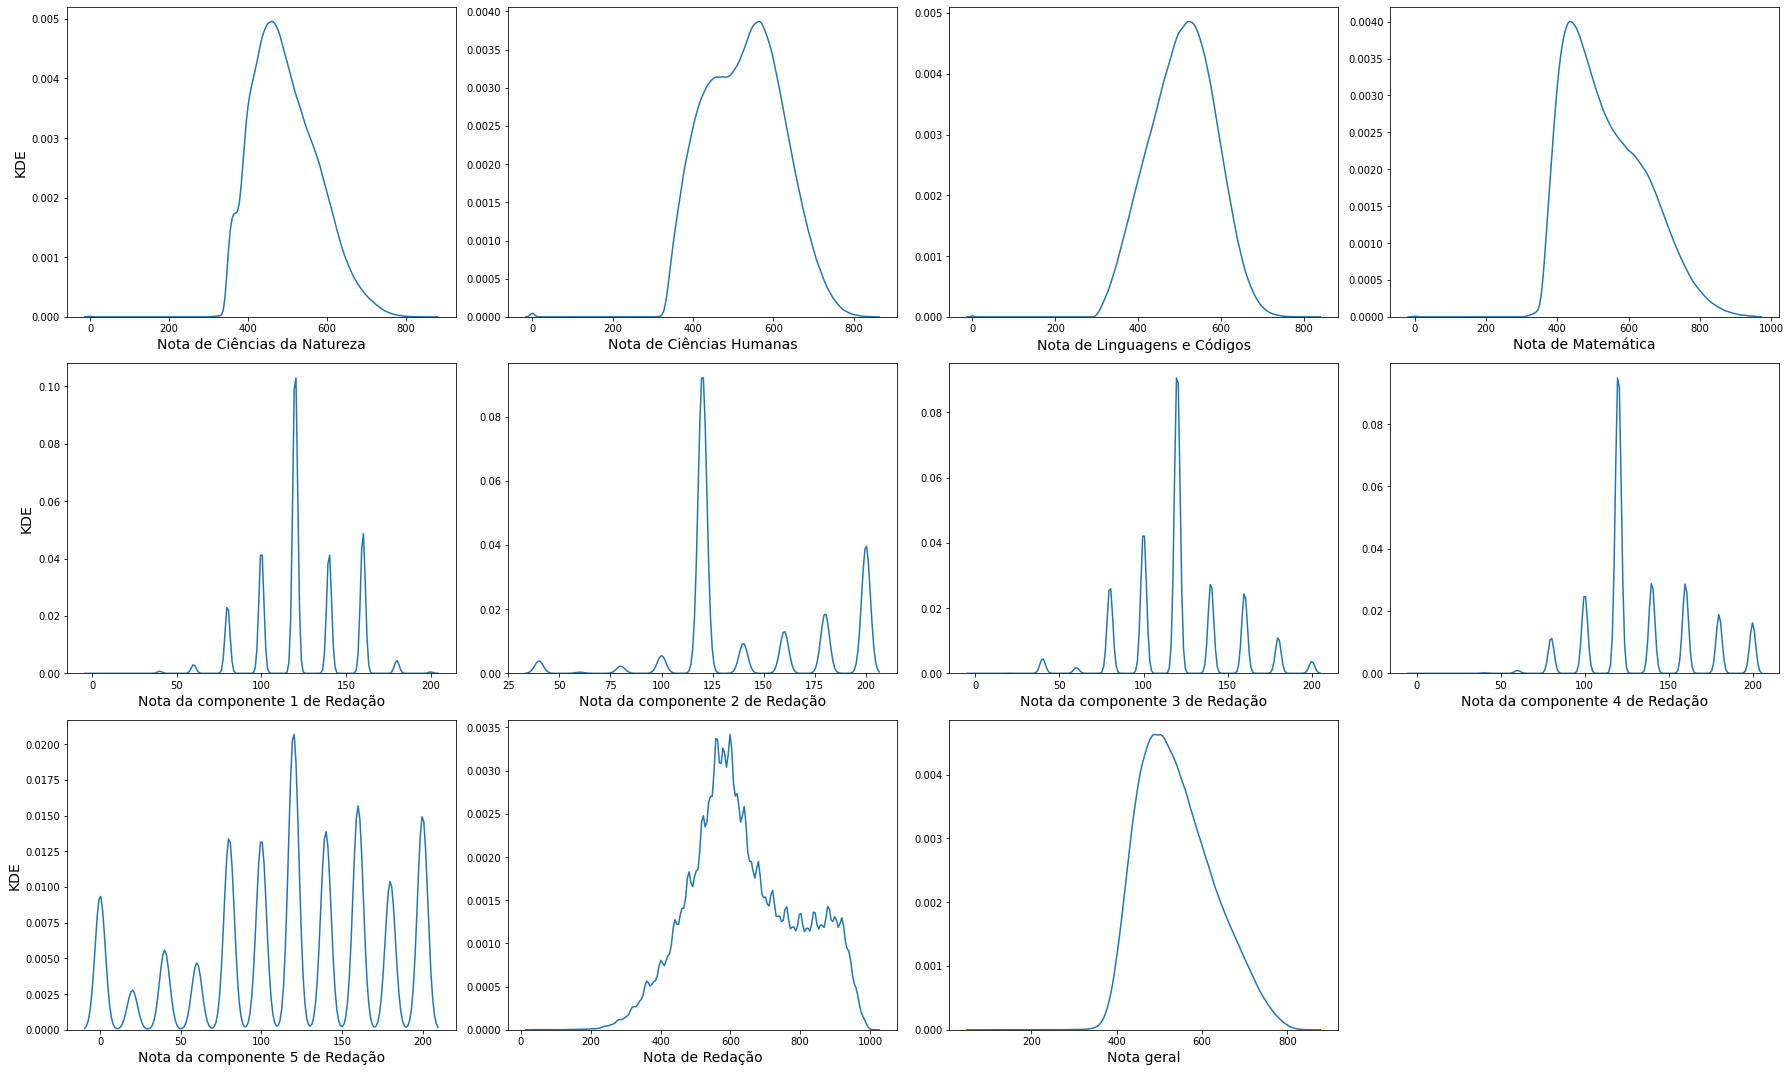

In [18]:
# Plotando a distribuição das features contínuas

feat_cont_labels = ['Nota de Ciências da Natureza', 'Nota de Ciências Humanas',
                    'Nota de Linguagens e Códigos', 'Nota de Matemática',
                    'Nota da componente 1 de Redação', 'Nota da componente 2 de Redação',
                    'Nota da componente 3 de Redação', 'Nota da componente 4 de Redação',
                    'Nota da componente 5 de Redação', 'Nota de Redação', 'Nota geral']

fig, axes = plt.subplots(3, 4, figsize=(25, 15))
count = 0

for row in range(3):
    for col in range(4):
        if count >= len(feat_cont):
            axes[row,col].axis('off')
        else:
            sns.kdeplot(ax=axes[row,col], data=df_EDA, x=feat_cont[count])
            axes[row,col].set_xlabel(feat_cont_labels[count], fontsize=14)
            if col == 0:
                axes[row,col].set_ylabel('KDE', fontsize=14)
            else:
                axes[row,col].set_ylabel(None)
            count += 1

plt.title('')
plt.tight_layout()
plt.show()

De modo geral, as distribuições são próximas à Normal.

Todavia, as curvas das notas das componentes da Redação - e, consequentemente, da nota geral da Redação -, apresentam diversos picos. Isto se dá pelo fato destas notas serem determinadas mediante a correção de profissionais individuais, os quais as computam em intervalos de 20 pontos.

Tal fenômeno não ocorre nas outras distribuições, pois seguem o modelo de Teoria de Resposta ao Item (TRI).

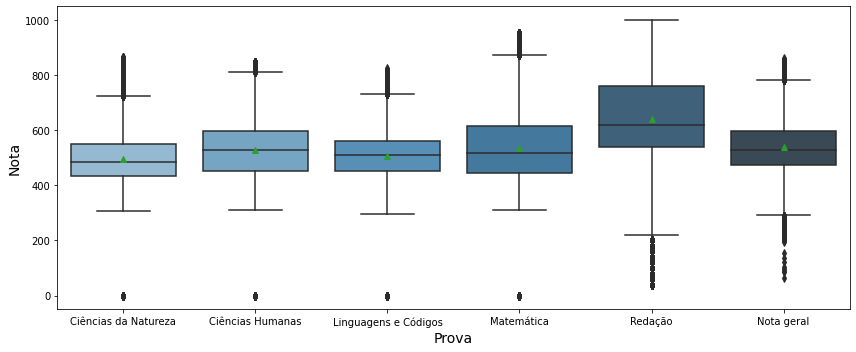

In [19]:
# Criando um DataFrame para auxiliar na visualização dos boxplots das features contínuas

df_EDA_boxplot = pd.melt(frame=df_EDA[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_GERAL']], var_name='Prova', value_name='Nota')
df_EDA_boxplot = df_EDA_boxplot.replace(to_replace=['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_GERAL'],
                                        value=['Ciências da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Nota geral'])

# Plotando os boxplots das features contínuas

plt.figure(figsize=(12,5))
sns.boxplot(data=df_EDA_boxplot, x='Prova', y='Nota', palette='Blues_d', showmeans=True)
plt.xlabel('Prova', fontsize=14)
plt.ylabel('Nota', fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
# Visualizando um resumo estatístico das notas obtidas nas provas

df_EDA[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_GERAL']].describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NOTA_GERAL
count,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06,1.822540e+06
mean,4.949590e+02,5.268001e+02,5.066880e+02,5.364632e+02,6.401850e+02,5.410191e+02
std,8.185698e+01,9.494125e+01,7.841577e+01,1.121918e+02,1.544641e+02,8.617681e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,6.400000e+01
25%,4.332000e+02,4.517000e+02,4.513000e+02,4.448000e+02,5.400000e+02,4.750200e+02
50%,4.846000e+02,5.292000e+02,5.097000e+02,5.158000e+02,6.200000e+02,5.298600e+02
75%,5.497000e+02,5.960000e+02,5.629000e+02,6.160000e+02,7.600000e+02,5.979800e+02
max,8.671000e+02,8.469000e+02,8.261000e+02,9.531000e+02,1.000000e+03,8.626800e+02


Apesar da existência de *outliers* - ou seja, notas muito inferiores ou muito superiores às demais -, estes são poucos, de modo que as médias das notas sejam muito próximas às suas respectivas medianas.

A prova de Redação apresentou a maior média de notas e, ao mesmo tempo, o maior desvio-padrão, evidenciando que, nesta área do conhecimento , as notas são bastante discrepantes.

Já as menores médias e os menores desvios-padrão foram obtidos nas provas de Ciências da Natureza (aprox. 495 e 82 pontos, respectivamente) e de Liguagens e Códigos (aprox. 507 e 78 pontos, respectivamente), revelando que, no geral, os candidatos possuem pouco conhecimento (ou interesse) nestas áreas.

In [21]:
# Renomeando alguns valores para facilitar a interpretação dos gráficos a seguir

original = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
            ['M', 'F'],
            [0, 1, 2, 3, 4],
            [0, 1, 2, 3, 4, 5, 6],
            [0, 1, 2, 3, 4],
            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            [1, 2, 3],
            ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
            ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
            ['A', 'B', 'C', 'D', 'E', 'F'],
            ['A', 'B', 'C', 'D', 'E', 'F'],
            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
            ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'],
            ['A', 'B', 'C', 'D', 'E'],
            ['A', 'B', 'C', 'D', 'E'],
            ['A', 'B']]

replace = [['Menor de 17 anos', '17 anos', '18 anos', '19 anos', '20 anos', '21 anos', '22 anos', '23 anos', '24 anos', '25 anos', 'Entre 26 e 30 anos', 'Entre 31 e 35 anos', 'Entre 36 e 40 anos', 'Entre 41 e 45 anos', 'Entre 46 e 50 anos', 'Entre 51 e 55 anos', 'Entre 56 e 60 anos', 'Entre 61 e 65 anos', 'Entre 66 e 70 anos', 'Maior que 70 anos'],
           ['Masculino', 'Feminino'],
           ['Não informado', 'Solteiro(a)', 'Casado(a)/Mora com companheiro(a)', 'Divorciado(a)/Desquitado(a)/Separado(a)', 'Viúvo(a)'],
           ['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena', 'Não dispõe da informação'],
           ['Não informado', 'Brasileiro(a)', 'Brasileiro(a) naturalizado(a)', 'Estrangeiro(a)', 'Brasileiro(a) nato(a), nascido(a) no exterior'],
           ['Não informado', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', 'Antes de 2007'],
           ['Não Respondeu', 'Pública', 'Privada'],
           ['Nunca estudou', 'Não completou o 5° ano do Ensino Fundamental', 'Completou o 5° ano, mas não completou o 9° ano do Ensino Fundamental', 'Completou o 9° ano do Ensino Fundamental, mas não completou o Ensino Médio', 'Completou o Ensino Médio, mas não completou a Faculdade', 'Completou a Faculdade, mas não completou a Pós-graduação', 'Completou a Pós-graduação', 'Não sei'],
           ['Nunca estudou', 'Não completou o 5° ano do Ensino Fundamental', 'Completou o 5° ano, mas não completou o 9° ano do Ensino Fundamental', 'Completou o 9° ano do Ensino Fundamental, mas não completou o Ensino Médio', 'Completou o Ensino Médio, mas não completou a Faculdade', 'Completou a Faculdade, mas não completou a Pós-graduação', 'Completou a Pós-graduação', 'Não sei'],
           ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Não sei'],
           ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Não sei'],
           ['1, pois moro sozinho(a)', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'],
           ['Nenhuma renda', 'Até R$ 1.100,00', 'De R\$ 1.100,01 até R\$ 1.650,00', 'De R\$ 1.650,01 até R\$ 2.200,00', 'De R\$ 2.200,01 até R\$ 2.750,00', 'De R\$ 2.750,01 até R\$ 3.300,00', 'De R\$ 3.300,01 até R\$ 4.400,00', 'De R\$ 4.400,01 até R\$ 5.500,00', 'De R\$ 5.500,01 até R\$ 6.600,00', 'De R\$ 6.600,01 até R\$ 7.700,00', 'De R\$ 7.700,01 até R\$ 8.800,00', 'De R\$ 8.800,01 até R\$ 9.900,00', 'De R\$ 9.900,01 até R\$ 11.000,00', 'De R\$ 11.000,01 até R\$ 13.200,00', 'De R\$ 13.200,01 até R\$ 16.500,00', 'De R\$ 16.500,01 até R\$ 22.000,00', 'Acima de R$ 22.000,00'],
           ['Não', 'Sim, um', 'Sim, dois', 'Sim, três', 'Sim, quatro ou mais'],
           ['Não', 'Sim, um', 'Sim, dois', 'Sim, três', 'Sim, quatro ou mais'],
           ['Não', 'Sim']]

count = 0

for feature in feat_cat:
    df_EDA[feature] = df_EDA[feature].replace(to_replace=original[count] , value=replace[count])
    count += 1

In [22]:
# Verificando se as renomeações foram executadas corretamente

df_EDA.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ANO_CONCLUIU,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,NOTA_GERAL
0,Entre 31 e 35 anos,Masculino,Solteiro(a),Branca,Brasileiro(a),2010,Não Respondeu,505.9,551.8,498.3,461.5,120.0,120.0,120.0,120.0,80.0,560.0,Não completou o 5° ano do Ensino Fundamental,Não completou o 5° ano do Ensino Fundamental,Grupo 2,Grupo 2,3,"Até R$ 1.100,00","Sim, dois",Não,Não,515.50
1,18 anos,Masculino,Solteiro(a),Parda,Brasileiro(a),Não informado,Pública,580.7,678.9,638.9,659.5,120.0,180.0,120.0,200.0,160.0,780.0,Não completou o 5° ano do Ensino Fundamental,Não completou o 5° ano do Ensino Fundamental,Grupo 2,Grupo 2,6,"Até R$ 1.100,00","Sim, um","Sim, um",Sim,667.60
2,17 anos,Feminino,Solteiro(a),Parda,Brasileiro(a),Não informado,Pública,497.7,532.4,457.6,582.6,120.0,140.0,160.0,180.0,180.0,780.0,"Completou o 9° ano do Ensino Fundamental, mas ...","Completou o Ensino Médio, mas não completou a ...",Não sei,Grupo 4,4,"De R\$ 1.100,01 até R\$ 1.650,00","Sim, quatro ou mais","Sim, um",Sim,570.06
3,23 anos,Feminino,Solteiro(a),Parda,Brasileiro(a),Não informado,Pública,487.4,476.5,450.7,493.4,120.0,120.0,80.0,100.0,100.0,520.0,Não completou o 5° ano do Ensino Fundamental,Não completou o 5° ano do Ensino Fundamental,Grupo 2,Grupo 2,2,"Até R$ 1.100,00","Sim, um",Não,Sim,485.60
4,19 anos,Feminino,Solteiro(a),Parda,Brasileiro(a),Não informado,Pública,507.6,539.2,494.6,413.3,80.0,120.0,80.0,80.0,20.0,380.0,"Completou o 9° ano do Ensino Fundamental, mas ...","Completou o 9° ano do Ensino Fundamental, mas ...",Grupo 4,Grupo 2,2,"Até R$ 1.100,00","Sim, dois",Não,Sim,466.94


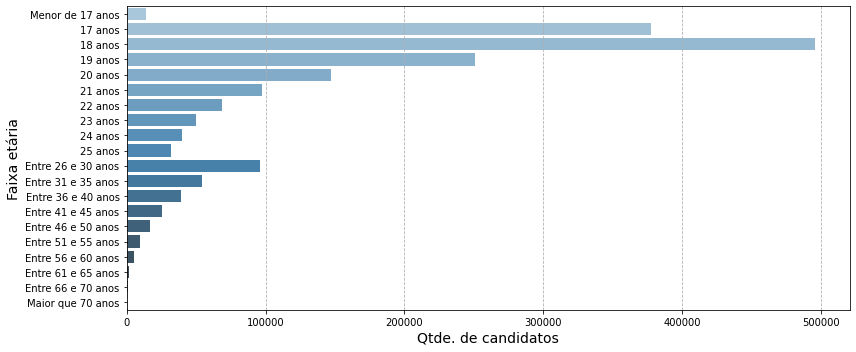

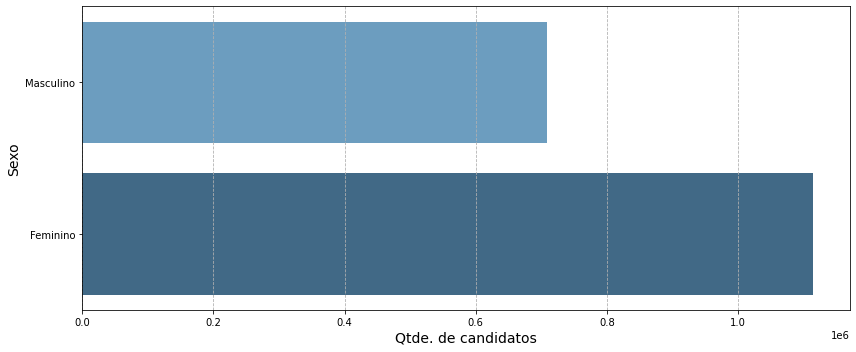

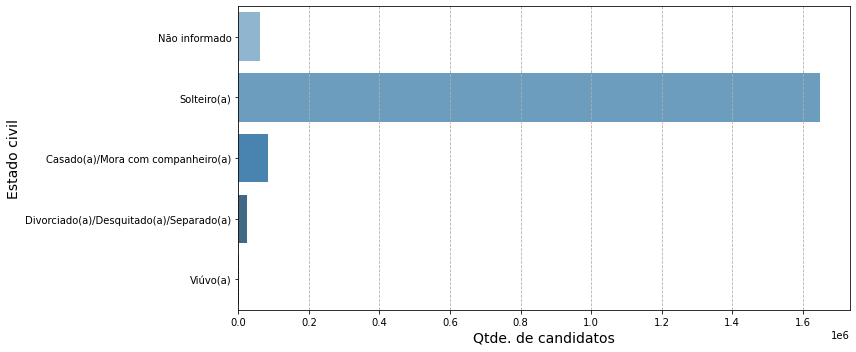

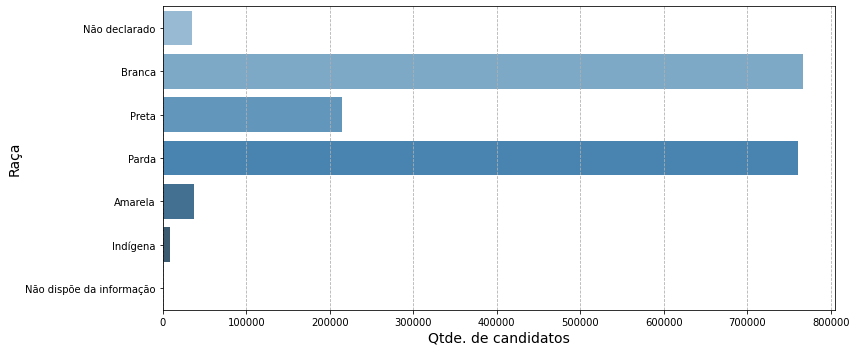

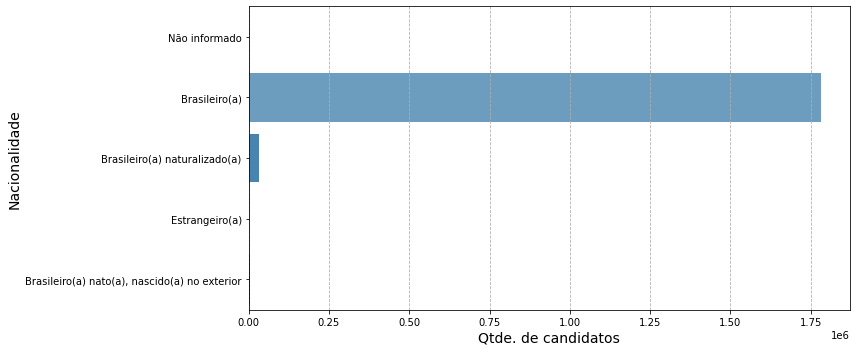

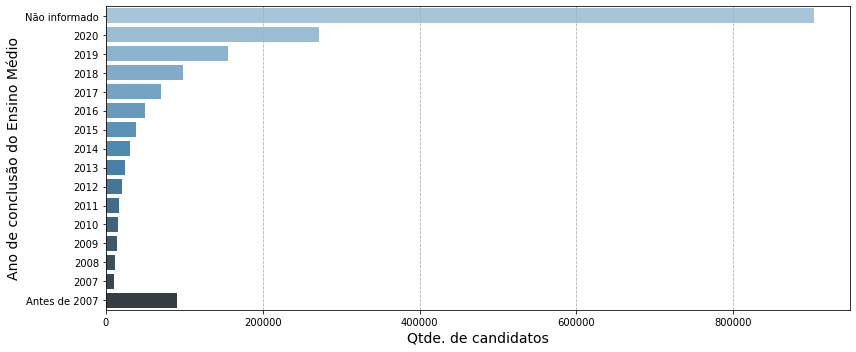

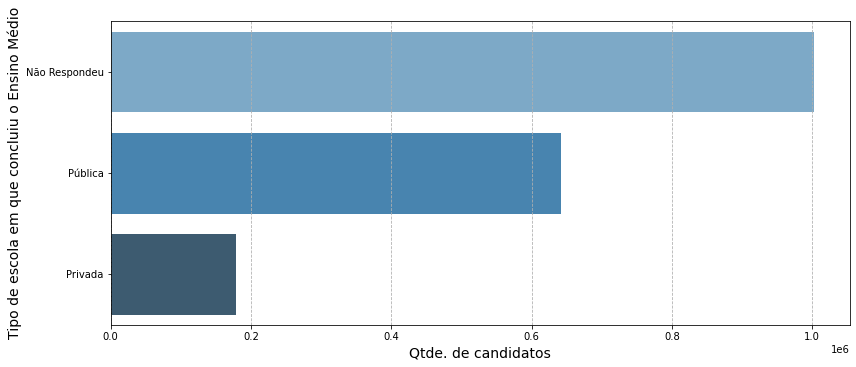

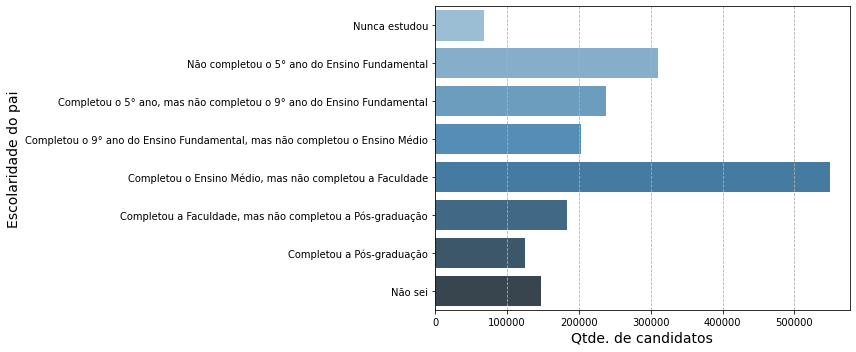

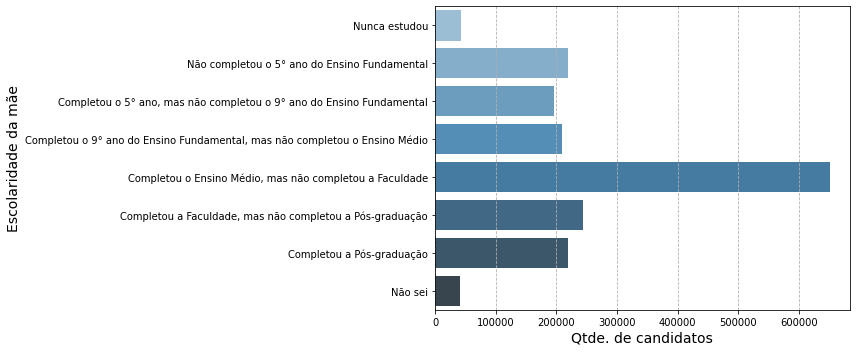

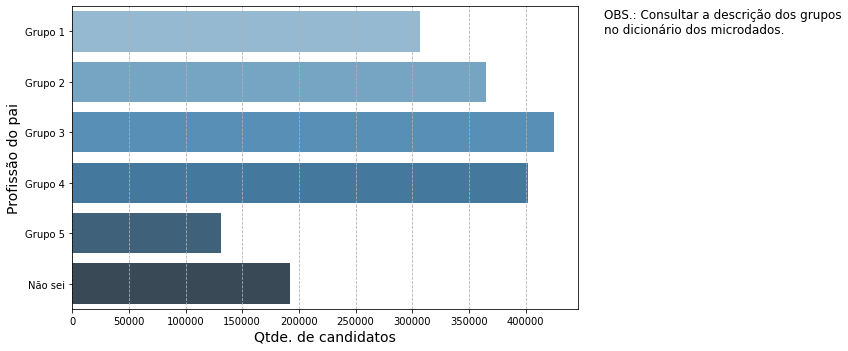

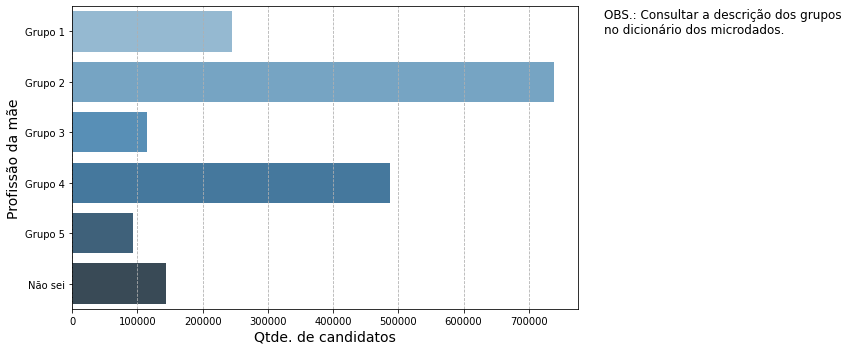

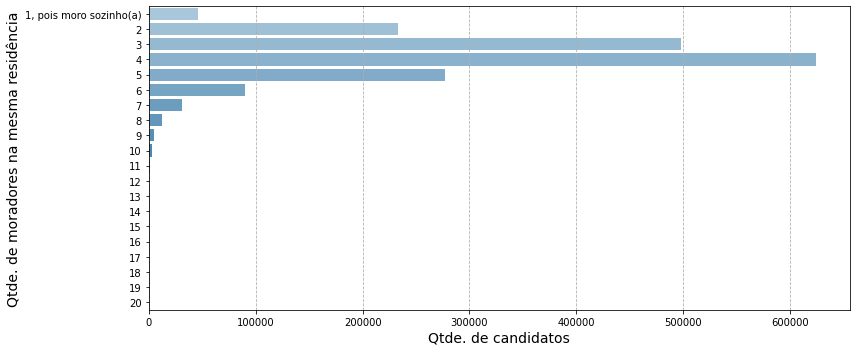

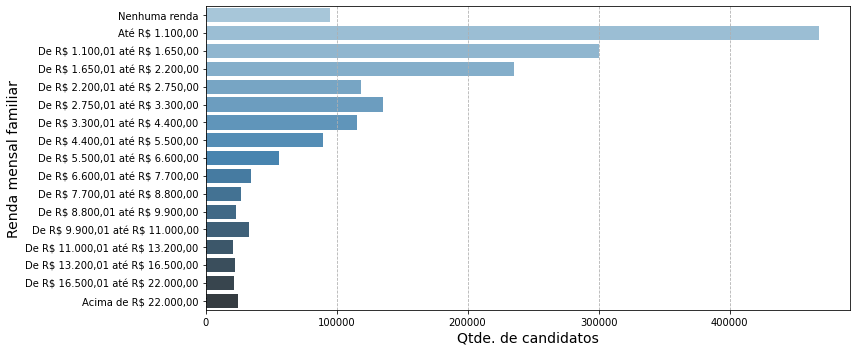

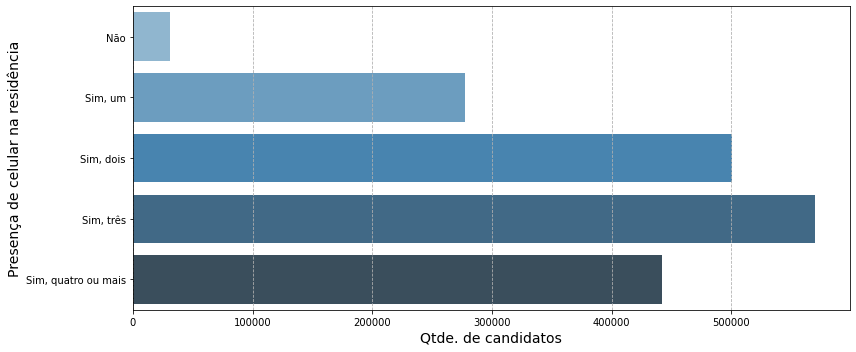

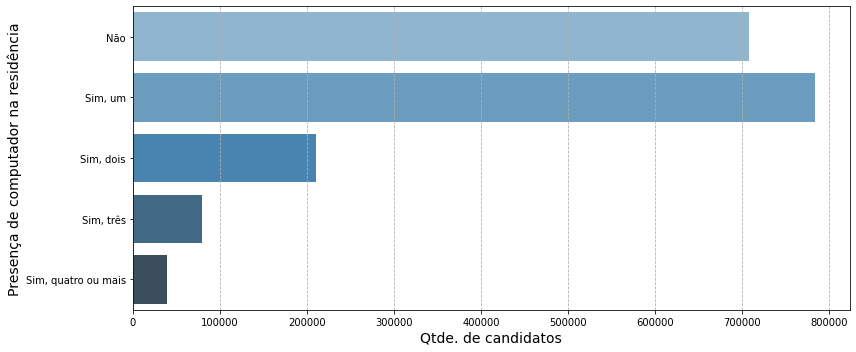

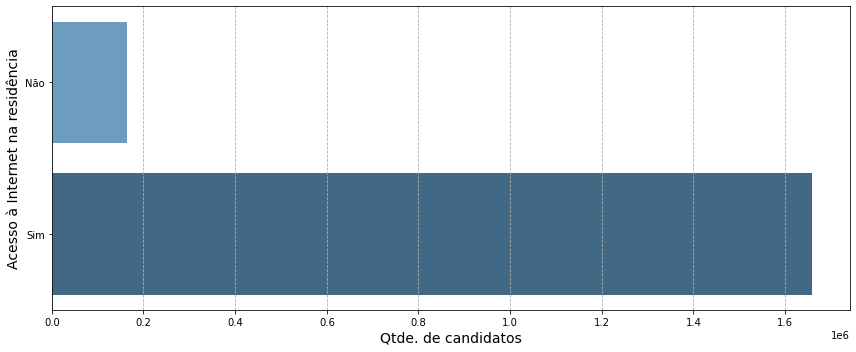

In [23]:
feat_cat_labels = ['Faixa etária', 'Sexo', 'Estado civil', 'Raça', 'Nacionalidade',
                   'Ano de conclusão do Ensino Médio', 'Tipo de escola em que concluiu o Ensino Médio',
                   'Escolaridade do pai', 'Escolaridade da mãe', 'Profissão do pai', 'Profissão da mãe',
                   'Qtde. de moradores na mesma residência', 'Renda mensal familiar', 'Presença de celular na residência',
                   'Presença de computador na residência', 'Acesso à Internet na residência']

# Plotando os gráficos de frequência das features categóricas

for count_feat in range(len(feat_cat)):
    
    if feat_cat[count_feat] in ['Q003', 'Q004']:
        plt.figure(figsize=(12,5))
        fig = sns.countplot(data=df_EDA, y=feat_cat[count_feat], order=replace[count_feat], palette='Blues_d')
        plt.xlabel('Qtde. de candidatos', fontsize=14)
        plt.ylabel(feat_cat_labels[count_feat], fontsize=14)
        plt.grid(axis='x', linestyle='--')
        plt.text(x=1.05, y=0.9, s='OBS.: Consultar a descrição dos grupos\nno dicionário dos microdados.', horizontalalignment='left', verticalalignment='bottom', transform=fig.transAxes, fontsize=12)
        plt.tight_layout()
        plt.show()  
    else:
        plt.figure(figsize=(12,5))
        sns.countplot(data=df_EDA, y=feat_cat[count_feat], order=replace[count_feat], palette='Blues_d')
        plt.xlabel('Qtde. de candidatos', fontsize=14)
        plt.ylabel(feat_cat_labels[count_feat], fontsize=14)
        plt.grid(axis='x', linestyle='--')
        plt.tight_layout()
        plt.show()

Algumas conclusões acerca da maioria dos candidatos (não-treineiros) que concluíram a prova:

- possui entre 17 e 20 anos;
- é do sexo feminino;
- é solteira;
- se auto-declara branca, preta ou parda;
- é brasileira;
- concluiu o Ensino Médio antes de 2007 ou entre 2017 e 2020 ou não informou o ano de conclusão;
- realizou o Ensino Médio em escola pública ou não informou o tipo de escola;
- possui pai/mãe que completou o Ensino Médio, mas não concluiu a Faculdade;
- possui pai cuja profissão é do grupo 1, 2, 3 ou 4;
- possui mãe cuja profissão é do grupo 2 ou 4;
- divide a residência com mais 1 até 4 pessoas;
- possui renda mensal familiar entre R\\$ 1.100,00 e R\\$ 2.200,00, destacando a grande desigualdade social que existe no Brasil, visto que existem famílias com renda mensal superior a R\\$ 22.000,00;
- possui pelo menos 1 celular na residência;
- não possui ou possui até 1 computador na residência;
- tem acesso à Internet na residência.

Outros aspectos interessantes a serem observados:

- Um dos motivos para a reduzida renda mensal familiar da maioria dos candidatos pode ser a ausência de Faculdade por parte do pai e/ou da mãe;
- É mais comum o candidato não conhecer a escolaridade e a profissão do pai do que da mãe. Tal fato pode ser explicado por alguns fatores sociais característicos ao Brasil, como a elevada taxa de mortalidade masculina ou o índice de abandono dos pais de suas famílias.

## 4.2. Análise bivariada

In [24]:
# Agrupando as classes minoritárias de algumas features

df_EDA['TP_FAIXA_ETARIA'][df_EDA['TP_FAIXA_ETARIA'].isin(['Entre 61 e 65 anos', 'Entre 66 e 70 anos', 'Maior que 70 anos'])] = 'Maior que 61 anos'
df_EDA['TP_ESTADO_CIVIL'][df_EDA['TP_ESTADO_CIVIL'].isin(['Casado(a)/Mora com companheiro(a)', 'Divorciado(a)/Desquitado(a)/Separado(a)', 'Não informado', 'Viúvo(a)'])] = 'Outro'
df_EDA['TP_COR_RACA'][df_EDA['TP_COR_RACA'].isin(['Amarela', 'Indígena', 'Não declarado', 'Não dispõe da informação'])] = 'Outra'
df_EDA['Q005'][df_EDA['Q005'].isin(['9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])] = 'Mais que 8'

# Visto que a imensa maioria dos candidatos é brasileira, optou-se por desconsiderar a coluna 'TP_NACIONALIDADE' da análise

df_EDA = df_EDA.drop('TP_NACIONALIDADE', axis=1)

# Atualizando as listas de características das features categóricas para remover a feature 'TP_NACIONALIDADE'

feat_cat = ['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_ANO_CONCLUIU',
            'TP_ESCOLA', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025']

feat_cat_labels = ['Faixa etária', 'Sexo', 'Estado civil', 'Raça', 'Ano de conclusão do Ensino Médio',
                   'Tipo de escola em que concluiu o Ensino Médio', 'Escolaridade do pai', 'Escolaridade da mãe',
                   'Profissão do pai', 'Profissão da mãe', 'Qtde. de moradores na mesma residência',
                   'Renda mensal familiar', 'Presença de celular na residência', 'Presença de computador na residência',
                   'Acesso à Internet na residência']

replace = [['Menor de 17 anos', '17 anos', '18 anos', '19 anos', '20 anos', '21 anos', '22 anos', '23 anos', '24 anos', '25 anos', 'Entre 26 e 30 anos', 'Entre 31 e 35 anos', 'Entre 36 e 40 anos', 'Entre 41 e 45 anos', 'Entre 46 e 50 anos', 'Entre 51 e 55 anos', 'Entre 56 e 60 anos', 'Maior que 61 anos'],
           ['Masculino', 'Feminino'],
           ['Solteiro(a)', 'Outro'],
           ['Branca', 'Preta', 'Parda', 'Outra'],
           ['Não informado', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', 'Antes de 2007'],
           ['Não Respondeu', 'Pública', 'Privada'],
           ['Nunca estudou', 'Não completou o 5° ano do Ensino Fundamental', 'Completou o 5° ano, mas não completou o 9° ano do Ensino Fundamental', 'Completou o 9° ano do Ensino Fundamental, mas não completou o Ensino Médio', 'Completou o Ensino Médio, mas não completou a Faculdade', 'Completou a Faculdade, mas não completou a Pós-graduação', 'Completou a Pós-graduação', 'Não sei'],
           ['Nunca estudou', 'Não completou o 5° ano do Ensino Fundamental', 'Completou o 5° ano, mas não completou o 9° ano do Ensino Fundamental', 'Completou o 9° ano do Ensino Fundamental, mas não completou o Ensino Médio', 'Completou o Ensino Médio, mas não completou a Faculdade', 'Completou a Faculdade, mas não completou a Pós-graduação', 'Completou a Pós-graduação', 'Não sei'],
           ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Não sei'],
           ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Não sei'],
           ['1, pois moro sozinho(a)', '2', '3', '4', '5', '6', '7', '8', 'Mais que 8'],
           ['Nenhuma renda', 'Até R$ 1.100,00', 'De R\$ 1.100,01 até R\$ 1.650,00', 'De R\$ 1.650,01 até R\$ 2.200,00', 'De R\$ 2.200,01 até R\$ 2.750,00', 'De R\$ 2.750,01 até R\$ 3.300,00', 'De R\$ 3.300,01 até R\$ 4.400,00', 'De R\$ 4.400,01 até R\$ 5.500,00', 'De R\$ 5.500,01 até R\$ 6.600,00', 'De R\$ 6.600,01 até R\$ 7.700,00', 'De R\$ 7.700,01 até R\$ 8.800,00', 'De R\$ 8.800,01 até R\$ 9.900,00', 'De R\$ 9.900,01 até R\$ 11.000,00', 'De R\$ 11.000,01 até R\$ 13.200,00', 'De R\$ 13.200,01 até R\$ 16.500,00', 'De R\$ 16.500,01 até R\$ 22.000,00', 'Acima de R$ 22.000,00'],
           ['Não', 'Sim, um', 'Sim, dois', 'Sim, três', 'Sim, quatro ou mais'],
           ['Não', 'Sim, um', 'Sim, dois', 'Sim, três', 'Sim, quatro ou mais'],
           ['Não', 'Sim']]

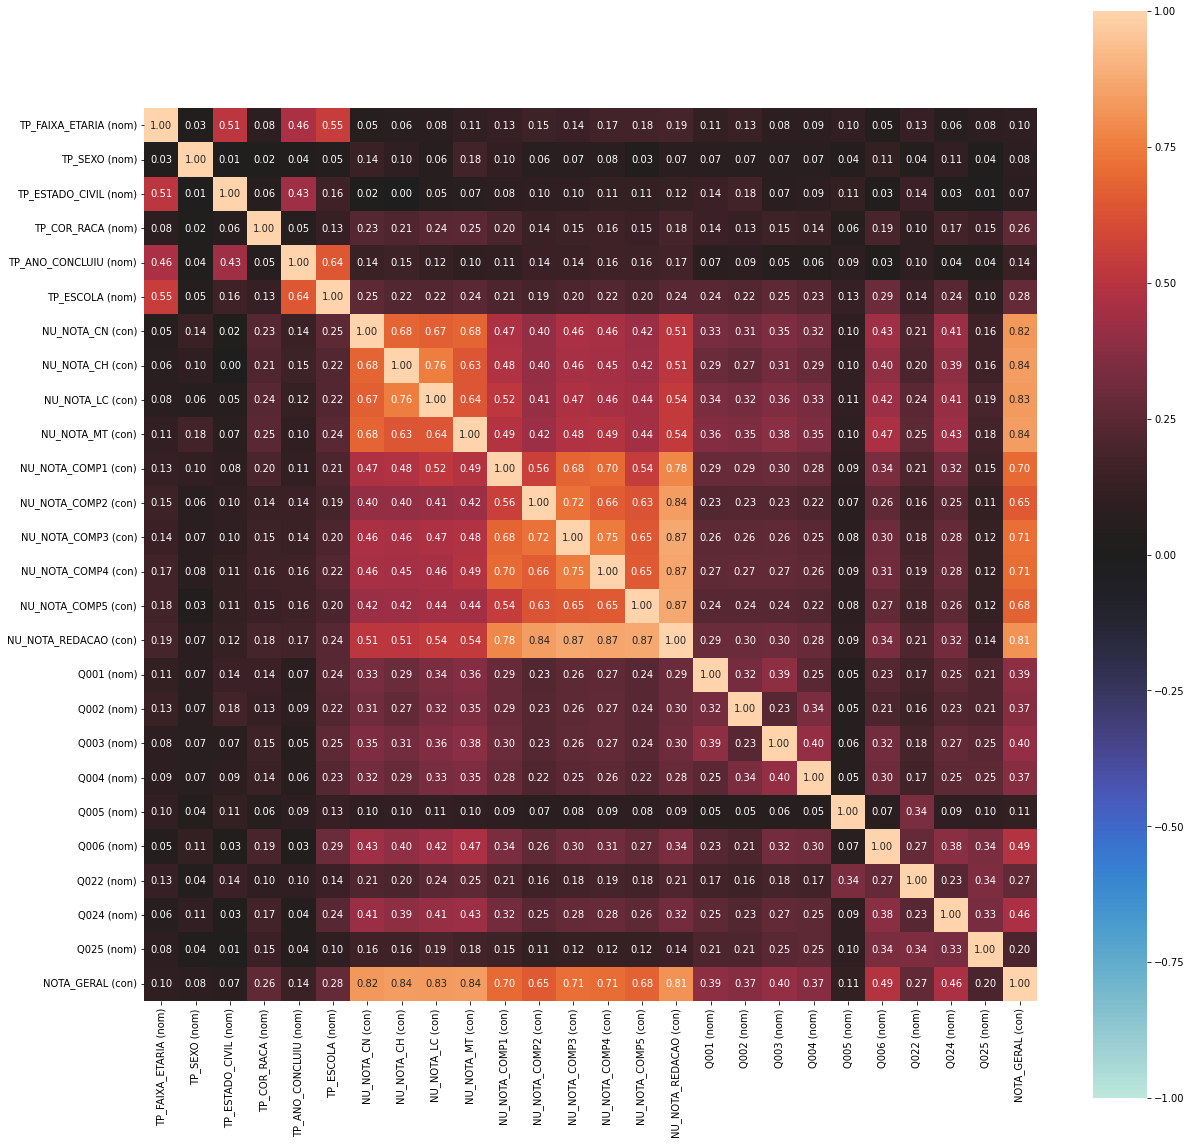

In [25]:
# Analisando a correlação entre as features

associations(dataset=df_EDA, nominal_columns=feat_cat, numerical_columns=feat_cont, mark_columns=True,
             nom_nom_assoc='cramer', num_num_assoc='pearson', nom_num_assoc='correlation_ratio', cramers_v_bias_correction=True,
             nan_strategy='replace', nan_replace_value=0.0, figsize=(20,20));

O mapa de correlação mostra que existe uma correlação moderada/boa entre as notas de todas as provas. Isto significa que, no geral, os candidatos costumam apresentar um desempenho homogêneo em todas as áreas do conhecimento.

Por outro lado, as correlações entre as *features* preditivas e a variável alvo ('NOTA_GERAL') são, em sua maioria, fracas.

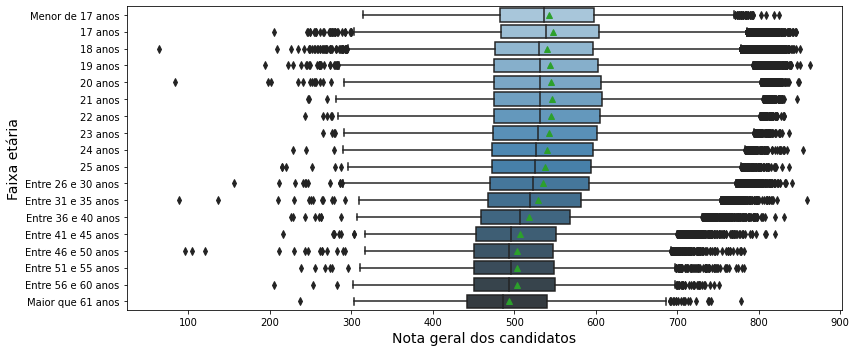

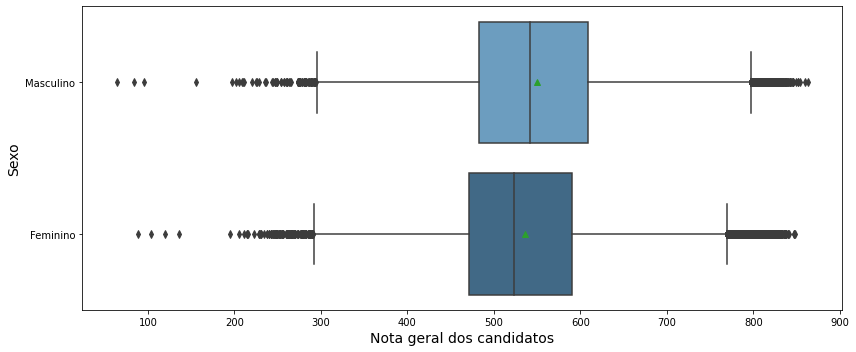

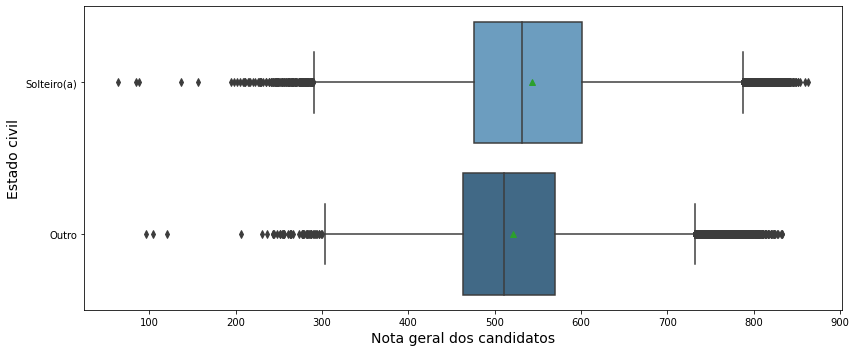

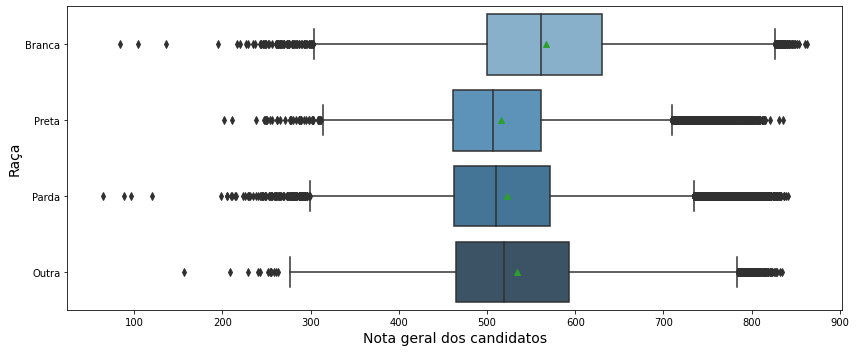

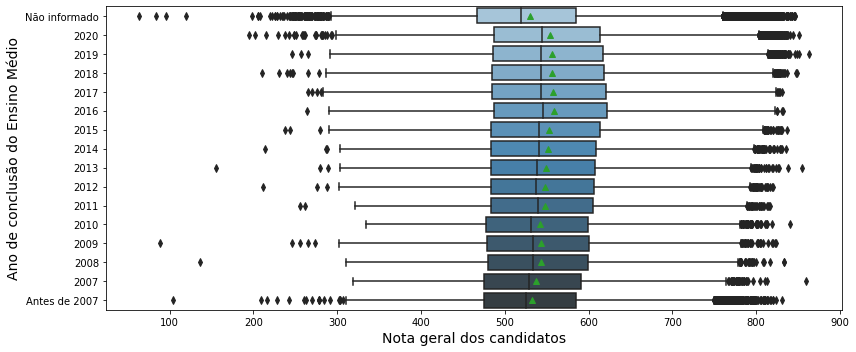

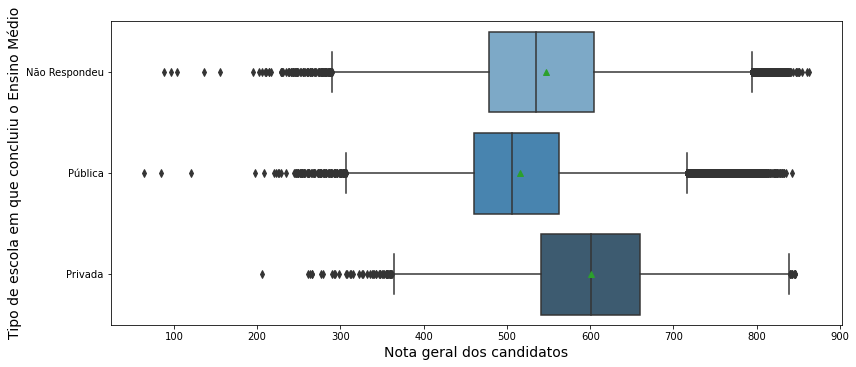

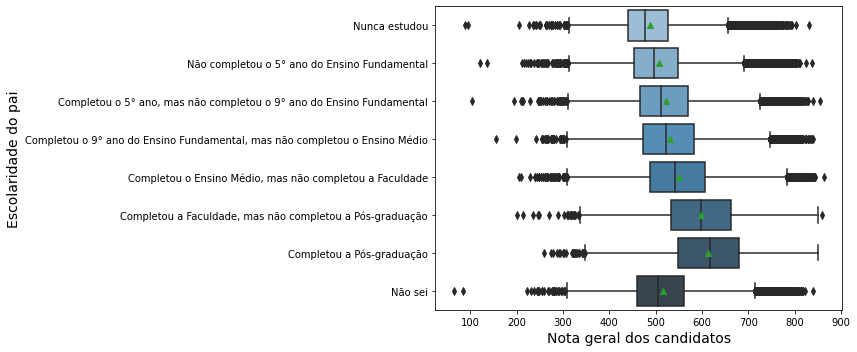

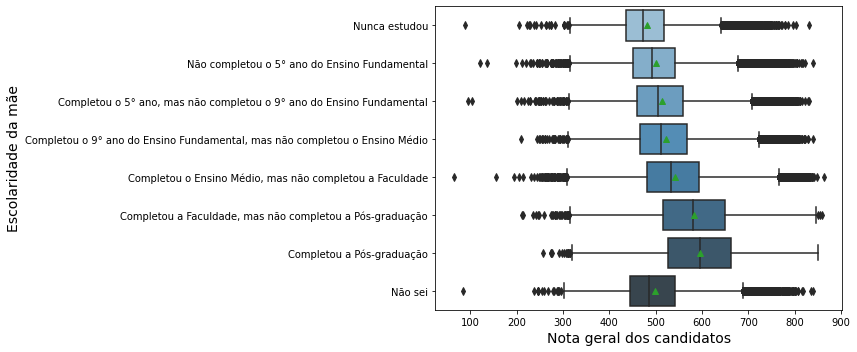

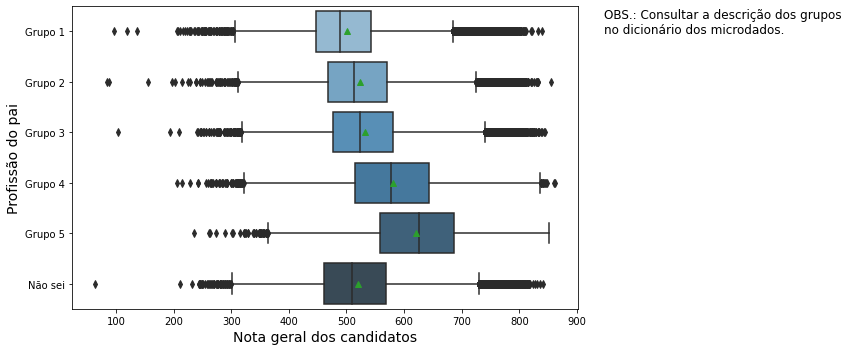

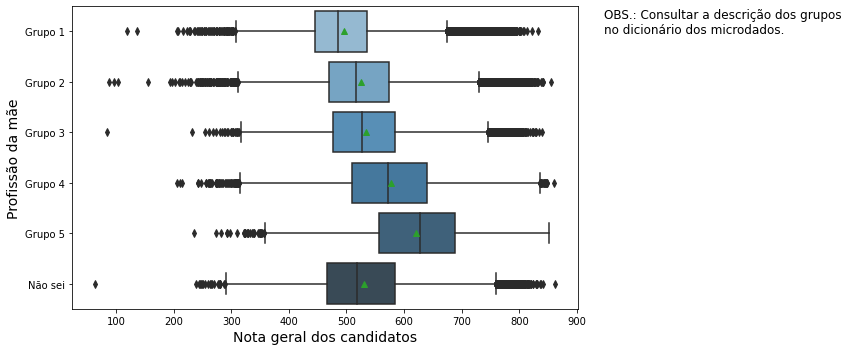

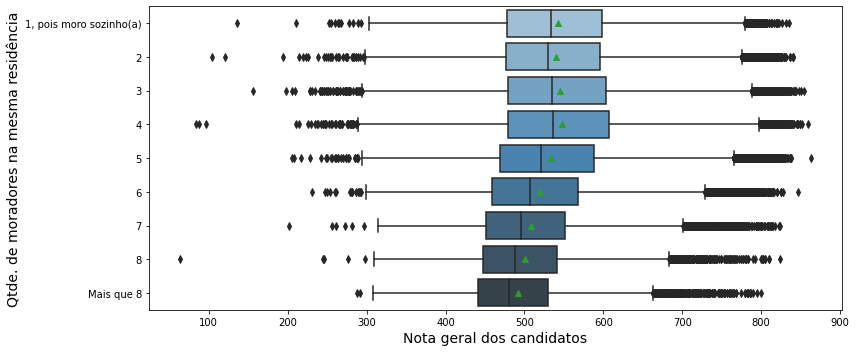

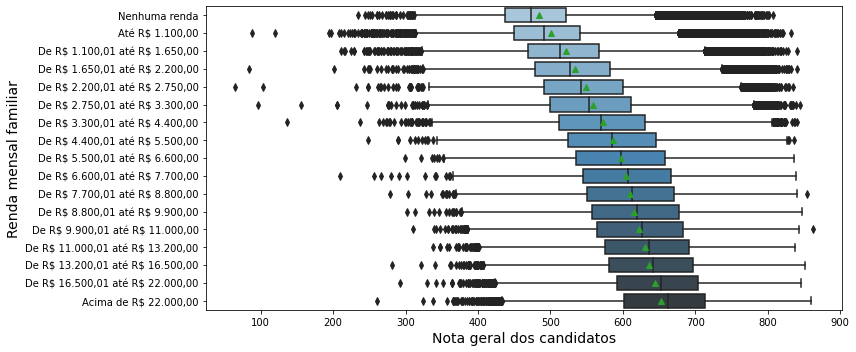

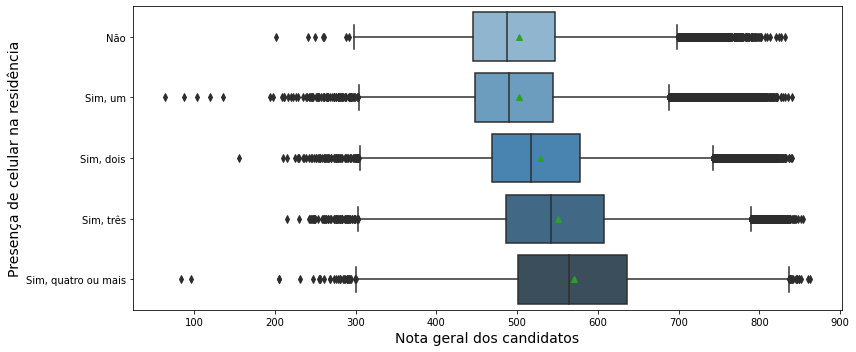

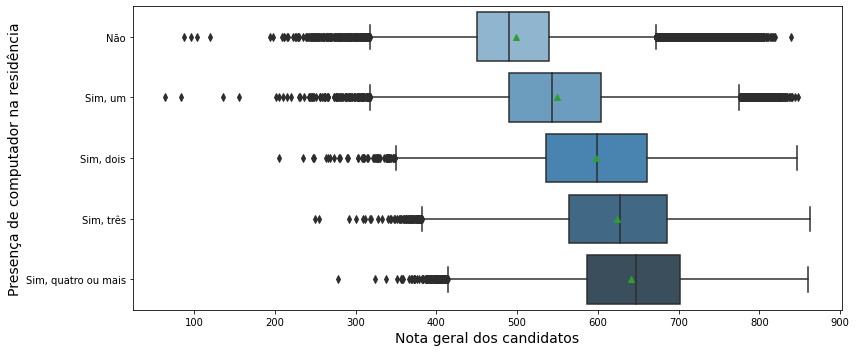

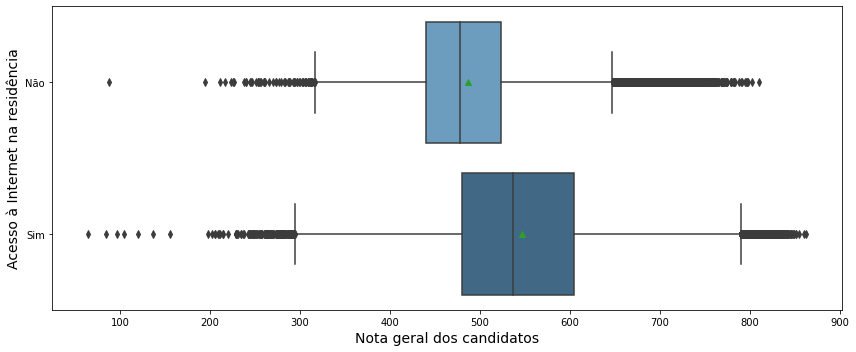

In [26]:
# Plotando os boxplots das features em função da nota geral dos candidatos

for count_feat in range(len(feat_cat)):
    if feat_cat[count_feat] in ['Q003', 'Q004']:
        plt.figure(figsize=(12,5))
        fig = sns.boxplot(data=df_EDA, x='NOTA_GERAL', y=feat_cat[count_feat], order=replace[count_feat], palette='Blues_d', showmeans=True)
        plt.xlabel('Nota geral dos candidatos', fontsize=14)
        plt.ylabel(feat_cat_labels[count_feat], fontsize=14)
        plt.text(x=1.05, y=0.9, s='OBS.: Consultar a descrição dos grupos\nno dicionário dos microdados.', horizontalalignment='left', verticalalignment='bottom', transform=fig.transAxes, fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(12,5))
        sns.boxplot(data=df_EDA, x='NOTA_GERAL' , y=feat_cat[count_feat], order=replace[count_feat], palette='Blues_d', showmeans=True)
        plt.xlabel('Nota geral dos candidatos', fontsize=14)
        plt.ylabel(feat_cat_labels[count_feat], fontsize=14)
        plt.tight_layout()
        plt.show()

As notas gerais mais elevadas foram obtidas pelos candidatos:

- com idade inferior a 23 anos;
- do sexo masculino;
- solteiros;
- que se auto-declaram brancos;
- que concluíram o Ensino Médio em escolas privadas;
- que possuem pai/mãe com pós-graduação completa e cuja profissão pertence ao grupo 5 (profissões mais prestigiadas);
- que dividem a residência com até 3 pessoas;
- cuja renda mensal familiar é superior a R$ 22.000,00;
- que possuem 4 ou mais celulares na residência;
- que possuem 4 ou mais computadores na residência;
- que possuem acesso à Internet na residência.

Pode-se verificar, então, que o desempenho do candidato no ENEM é diretamente proporcional ao nível socioeconômico ao qual ele está incluído, ou seja, indivíduos com melhores condições socioeconômicas tendem a apresentar melhores resultados nas provas e vice-versa. Há diversos motivos para tal conclusão, como:

- Acesso à educação de maior qualidade;
- Mais suporte emocional por parte da família e dos amigos;
- Ausência da necessidade de sustentar financeiramente a família ou a si mesmo, havendo, assim, mais tempo para se dedicar aos estudos;
- Entre outros.

# 5. Modelo preditivo

## 5.1. Engenharia de variáveis

In [27]:
# Criando um DataFrame para manipular as features preditoras

df_ML = df_EDA[feat_cat + ['NOTA_GERAL']]

In [28]:
# Convertendo as features categóricas em numéricas para que possam ser utilizadas pelo modelo de Machine Learning

for feat in df_ML.drop('NOTA_GERAL', axis=1).columns:
    if feat in ['TP_COR_RACA', 'TP_ESCOLA']:
        df_ML = pd.concat([df_ML.drop(feat, axis=1), pd.get_dummies(data=df_ML[feat], prefix=feat)], axis=1)
    else:
        label, val = pd.factorize(values=df_ML[feat])
        df_ML[feat] = label

In [29]:
# Verificando se a conversão do formato das features foi executada corretamente

df_ML.info()
display(df_ML.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1822540 entries, 0 to 1822540
Data columns (total 21 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   TP_FAIXA_ETARIA          int64  
 1   TP_SEXO                  int64  
 2   TP_ESTADO_CIVIL          int64  
 3   TP_ANO_CONCLUIU          int64  
 4   Q001                     int64  
 5   Q002                     int64  
 6   Q003                     int64  
 7   Q004                     int64  
 8   Q005                     int64  
 9   Q006                     int64  
 10  Q022                     int64  
 11  Q024                     int64  
 12  Q025                     int64  
 13  NOTA_GERAL               float64
 14  TP_COR_RACA_Branca       uint8  
 15  TP_COR_RACA_Outra        uint8  
 16  TP_COR_RACA_Parda        uint8  
 17  TP_COR_RACA_Preta        uint8  
 18  TP_ESCOLA_Não Respondeu  uint8  
 19  TP_ESCOLA_Privada        uint8  
 20  TP_ESCOLA_Pública        uint8  
dtypes: float

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,NOTA_GERAL,TP_COR_RACA_Branca,TP_COR_RACA_Outra,TP_COR_RACA_Parda,TP_COR_RACA_Preta,TP_ESCOLA_Não Respondeu,TP_ESCOLA_Privada,TP_ESCOLA_Pública
0,0,0,0,0,0,0,0,0,0,0,0,0,0,515.50,1,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,1,0,1,1,1,667.60,0,0,1,0,0,0,1
2,2,1,0,1,1,1,1,1,2,1,2,1,1,570.06,0,0,1,0,0,0,1
3,3,1,0,1,0,0,0,0,3,0,1,0,1,485.60,0,0,1,0,0,0,1
4,4,1,0,1,1,2,2,0,3,0,0,0,1,466.94,0,0,1,0,0,0,1


## 5.2. Divisão dos dados entre treino e teste

In [30]:
X = df_ML.drop('NOTA_GERAL', axis=1)
y = df_ML['NOTA_GERAL']

seed = 0

# Construindo os datasets de treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print('Dimensão dos datasets:')
print()
print('X:', X.shape)
print('y:', y.shape)
print('X_training:', X_training.shape)
print('y_training:', y_training.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

Dimensão dos datasets:

X: (1822540, 20)
y: (1822540,)
X_training: (1366905, 20)
y_training: (1366905,)
X_test: (455635, 20)
y_test: (455635,)


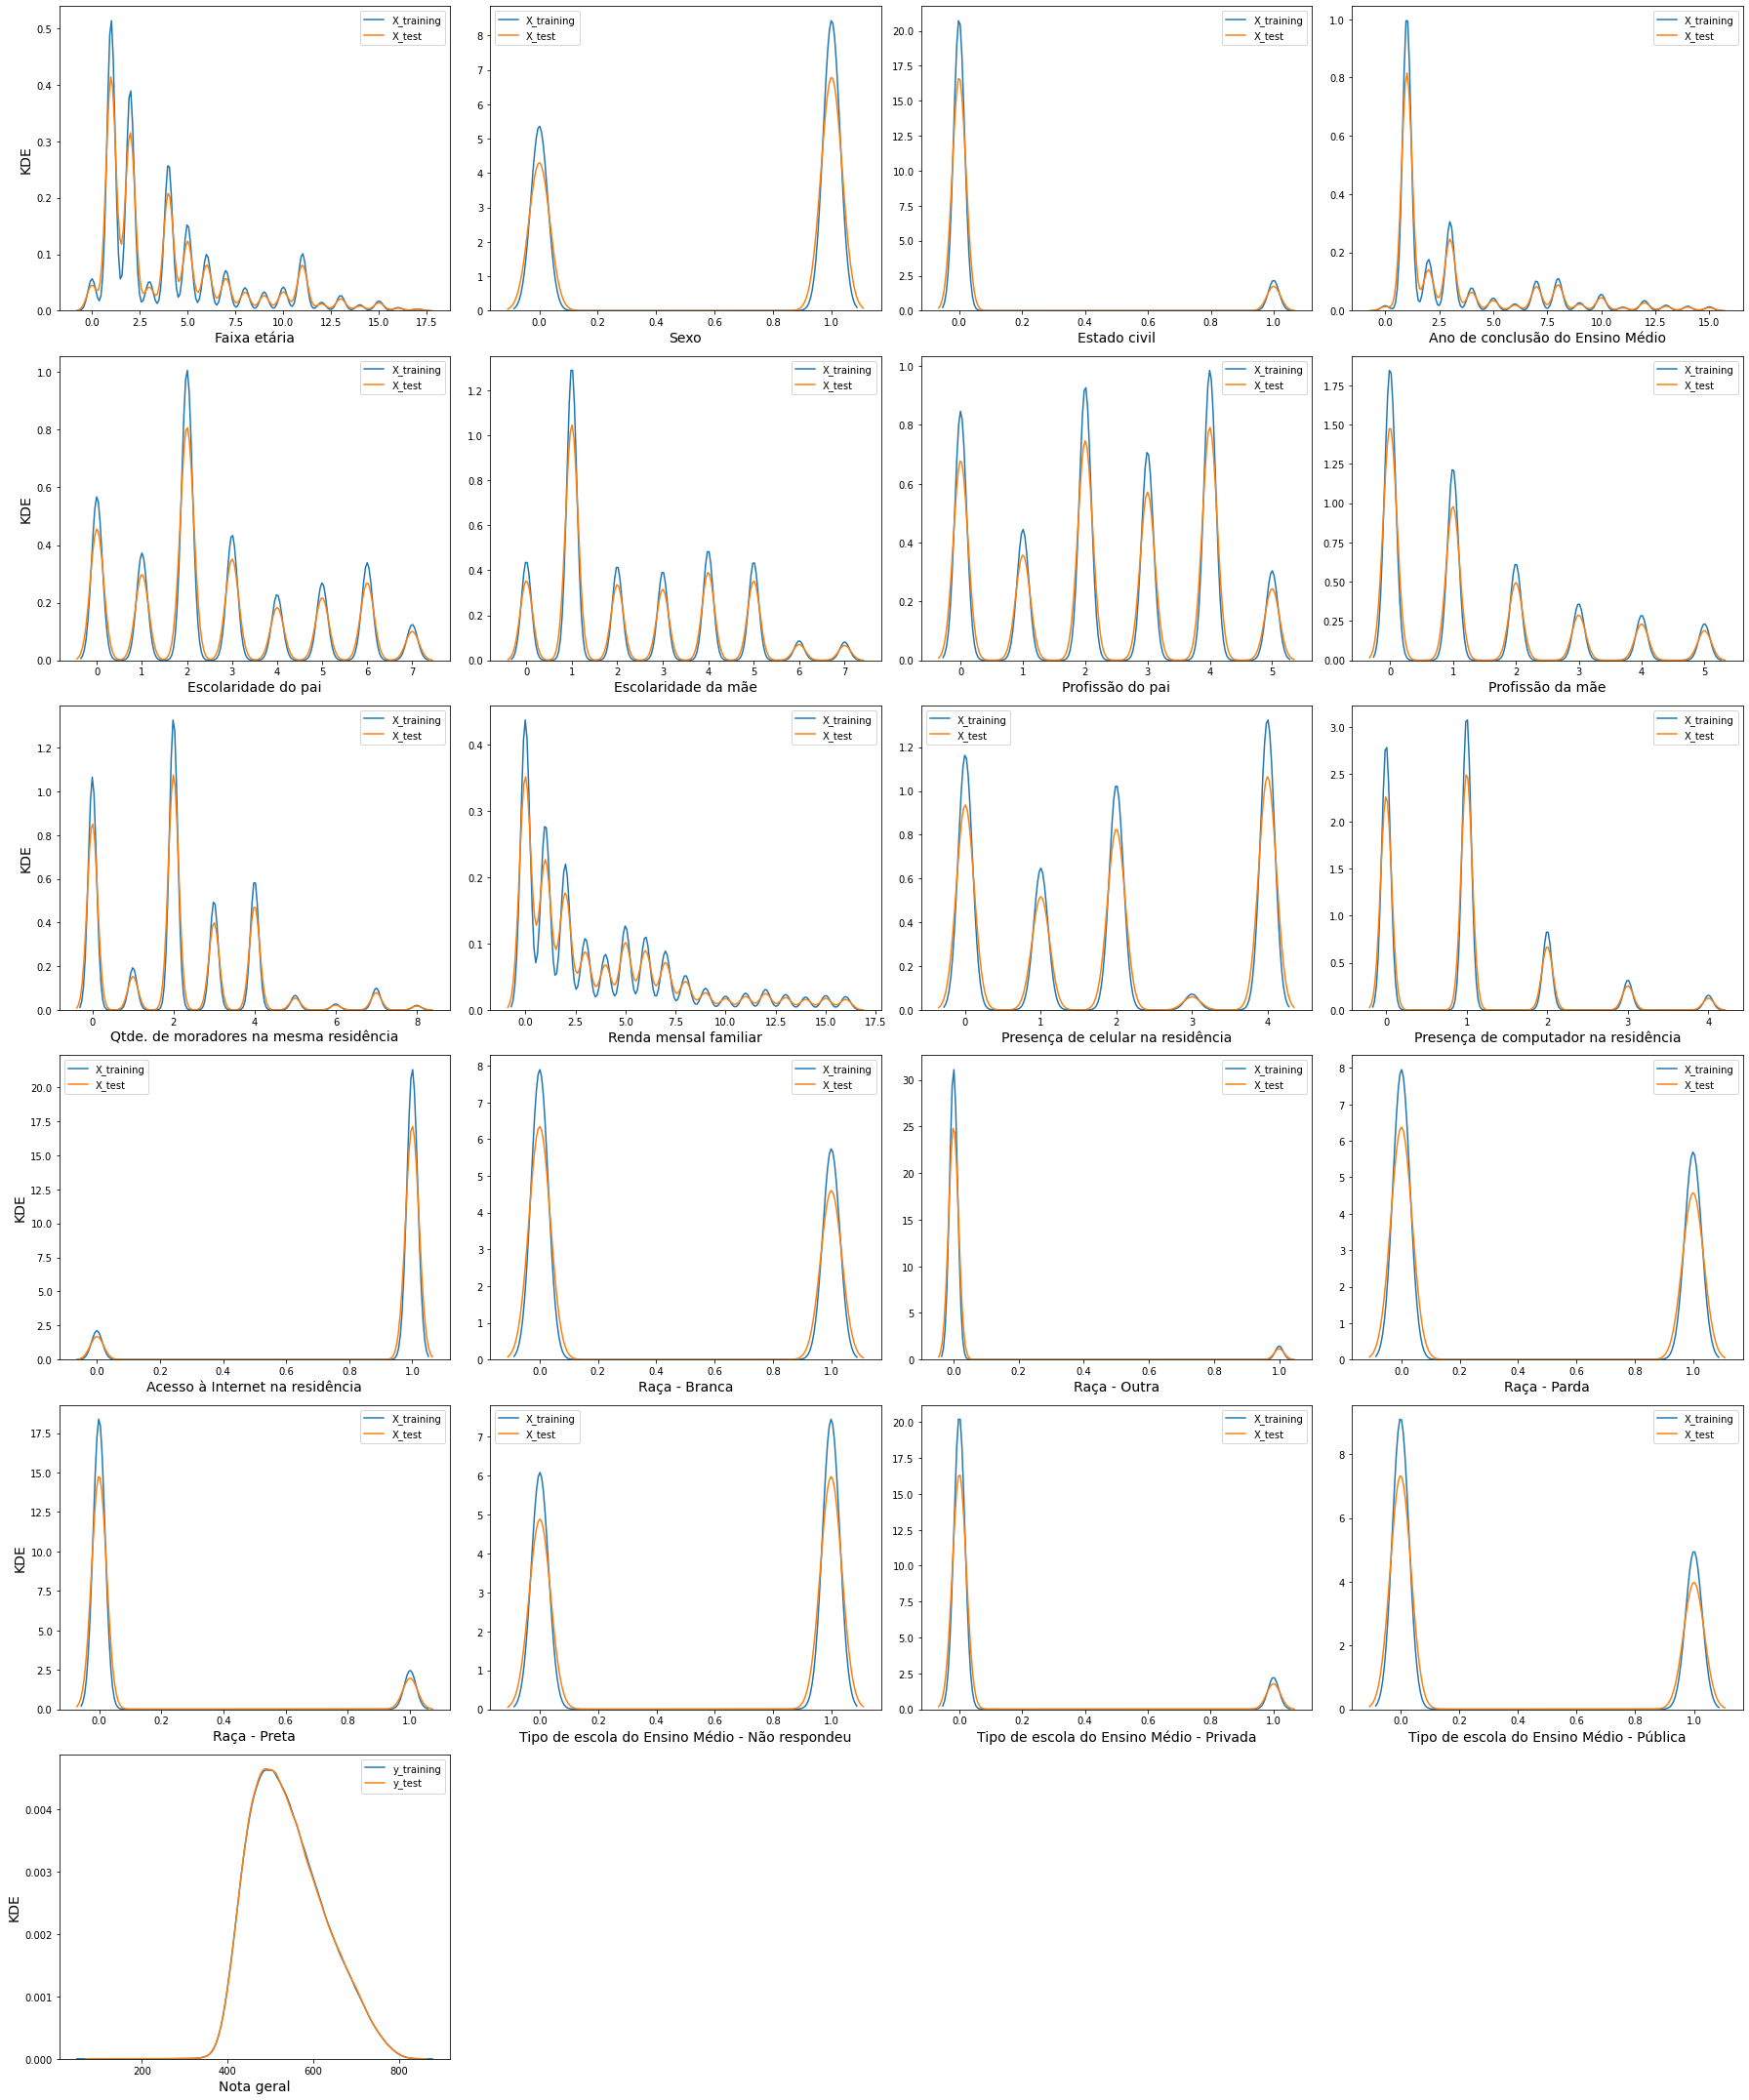

In [31]:
# Verificando se a distribuição de cada feature é similar em todos os datasets

feat_ML = X.columns
feat_ML_labels = ['Faixa etária', 'Sexo', 'Estado civil', 'Ano de conclusão do Ensino Médio', 'Escolaridade do pai',
                  'Escolaridade da mãe', 'Profissão do pai', 'Profissão da mãe', 'Qtde. de moradores na mesma residência',
                  'Renda mensal familiar', 'Presença de celular na residência', 'Presença de computador na residência',
                  'Acesso à Internet na residência', 'Raça - Branca', 'Raça - Outra', 'Raça - Parda', 'Raça - Preta',
                  'Tipo de escola do Ensino Médio - Não respondeu', 'Tipo de escola do Ensino Médio - Privada',
                  'Tipo de escola do Ensino Médio - Pública']

graph_titles = ['X_training vs. X_test', 'y_training vs. y_test']

fig, axes = plt.subplots(6, 4, figsize=(25, 30))
count = 0

for row in range(6):
    for col in range(4):
        if count > len(feat_ML):
            axes[row,col].axis('off')
        else:
            if count < len(feat_ML):
                sns.kdeplot(ax=axes[row,col], data=X_training, x=feat_ML[count])
                sns.kdeplot(ax=axes[row,col], data=X_test, x=feat_ML[count])
                axes[row,col].set_xlabel(feat_ML_labels[count], fontsize=14)
                axes[row,col].legend(['X_training', 'X_test'])
                if col == 0:
                    axes[row,col].set_ylabel('KDE', fontsize=14)
                else:
                    axes[row,col].set_ylabel(None)
            else:
                sns.kdeplot(ax=axes[row,col], data=y_training)
                sns.kdeplot(ax=axes[row,col], data=y_test)
                axes[row,col].set_xlabel('Nota geral', fontsize=14)
                axes[row,col].legend(['y_training', 'y_test'])
                if col == 0:
                    axes[row,col].set_ylabel('KDE', fontsize=14)
                else:
                    axes[row,col].set_ylabel(None)
            count += 1

plt.title('')
plt.tight_layout()
plt.show()

A distribuição de cada *feature* é similar em todos os *datasets*.

## 5.3. Normalização dos dados

In [32]:
# Executando a normalização via Standard Scaling

scaler = preprocessing.StandardScaler()
X_training_scaled = scaler.fit_transform(X_training)
X_training_scaled = pd.DataFrame(X_training_scaled, index=X_training.index, columns=feat_ML)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=feat_ML)

In [33]:
# Verificando se a normalização foi aplicada corretamente

print('X_training antes da normalização:')
display(X_training.describe())
print()
print('X_training após a normalização:')
display(X_training_scaled.describe())
print()
print('X_test antes da normalização:')
display(X_test.describe())
print()
print('X_test após a normalização:')
display(X_test_scaled.describe())

X_training antes da normalização:


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,TP_COR_RACA_Branca,TP_COR_RACA_Outra,TP_COR_RACA_Parda,TP_COR_RACA_Preta,TP_ESCOLA_Não Respondeu,TP_ESCOLA_Privada,TP_ESCOLA_Pública
count,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06
mean,4.000458e+00,6.113117e-01,9.423771e-02,3.203058e+00,2.647850e+00,2.342479e+00,2.344658e+00,1.277125e+00,2.076108e+00,3.577240e+00,1.940624e+00,8.787685e-01,9.095307e-01,4.208508e-01,4.434105e-02,4.170875e-01,1.177207e-01,5.505291e-01,9.765638e-02,3.518145e-01
std,3.544119e+00,4.874524e-01,2.921593e-01,3.282255e+00,2.011553e+00,1.838160e+00,1.593274e+00,1.467987e+00,1.723011e+00,3.948385e+00,1.586650e+00,9.261853e-01,2.868531e-01,4.936958e-01,2.058518e-01,4.930778e-01,3.222772e-01,4.974404e-01,2.968496e-01,4.775366e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.700000e+01,1.000000e+00,1.000000e+00,1.500000e+01,7.000000e+00,7.000000e+00,5.000000e+00,5.000000e+00,8.000000e+00,1.600000e+01,4.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00



X_training após a normalização:


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,TP_COR_RACA_Branca,TP_COR_RACA_Outra,TP_COR_RACA_Parda,TP_COR_RACA_Preta,TP_ESCOLA_Não Respondeu,TP_ESCOLA_Privada,TP_ESCOLA_Pública
count,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06,1.366905e+06
mean,2.357222e-15,1.434821e-14,-1.222701e-14,2.697329e-16,-2.994846e-15,4.997774e-16,3.674551e-16,5.792918e-16,-3.553934e-15,6.789330e-16,-1.853309e-15,1.137054e-14,5.150833e-15,-1.884231e-16,1.135577e-16,-2.264222e-15,-3.950890e-15,5.433816e-15,-2.426657e-15,-6.775520e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.128760e+00,-1.254095e+00,-3.225561e-01,-9.758715e-01,-1.316322e+00,-1.274361e+00,-1.471598e+00,-8.699841e-01,-1.204931e+00,-9.060012e-01,-1.223096e+00,-9.488045e-01,-3.170720e+00,-8.524498e-01,-2.154029e-01,-8.458861e-01,-3.652779e-01,-1.106724e+00,-3.289761e-01,-7.367281e-01
25%,-8.466022e-01,-1.254095e+00,-3.225561e-01,-6.712028e-01,-8.191934e-01,-7.303388e-01,-8.439593e-01,-8.699841e-01,-1.204931e+00,-9.060012e-01,-1.223096e+00,-9.488045e-01,3.153857e-01,-8.524498e-01,-2.154029e-01,-8.458861e-01,-3.652779e-01,-1.106724e+00,-3.289761e-01,-7.367281e-01
50%,-5.644446e-01,7.973874e-01,-3.225561e-01,-6.712028e-01,-3.220649e-01,-1.863162e-01,-2.163208e-01,-1.887788e-01,-4.417177e-02,-3.994647e-01,3.742210e-02,1.308934e-01,3.153857e-01,-8.524498e-01,-2.154029e-01,-8.458861e-01,-3.652779e-01,9.035676e-01,-3.289761e-01,-7.367281e-01
75%,2.820285e-01,7.973874e-01,-3.225561e-01,2.428033e-01,6.721921e-01,9.017290e-01,1.038956e+00,4.924266e-01,5.362077e-01,6.136082e-01,1.297940e+00,1.308934e-01,3.153857e-01,1.173090e+00,-2.154029e-01,1.182192e+00,-3.652779e-01,9.035676e-01,-3.289761e-01,1.357353e+00
max,3.667921e+00,7.973874e-01,3.100236e+00,3.594159e+00,2.163578e+00,2.533797e+00,1.666595e+00,2.536043e+00,3.438105e+00,3.146290e+00,1.297940e+00,3.369987e+00,3.153857e-01,1.173090e+00,4.642463e+00,1.182192e+00,2.737642e+00,9.035676e-01,3.039735e+00,1.357353e+00



X_test antes da normalização:


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,TP_COR_RACA_Branca,TP_COR_RACA_Outra,TP_COR_RACA_Parda,TP_COR_RACA_Preta,TP_ESCOLA_Não Respondeu,TP_ESCOLA_Privada,TP_ESCOLA_Pública
count,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000
mean,4.000992,0.612067,0.094854,3.202790,2.647011,2.345998,2.345252,1.282369,2.075850,3.577291,1.941431,0.878429,0.909733,0.420304,0.044639,0.417668,0.117390,0.550294,0.097749,0.351957
std,3.548343,0.487280,0.293014,3.279576,2.010125,1.841792,1.593298,1.471490,1.723822,3.947262,1.586723,0.925887,0.286565,0.493608,0.206510,0.493175,0.321885,0.497465,0.296976,0.477581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,4.000000,4.000000,4.000000,4.000000,2.000000,3.000000,6.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,17.000000,1.000000,1.000000,15.000000,7.000000,7.000000,5.000000,5.000000,8.000000,16.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



X_test após a normalização:


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ANO_CONCLUIU,Q001,Q002,Q003,Q004,Q005,Q006,Q022,Q024,Q025,TP_COR_RACA_Branca,TP_COR_RACA_Outra,TP_COR_RACA_Parda,TP_COR_RACA_Preta,TP_ESCOLA_Não Respondeu,TP_ESCOLA_Privada,TP_ESCOLA_Pública
count,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000,455635.000000
mean,0.000151,0.001549,0.002111,-0.000082,-0.000417,0.001915,0.000373,0.003572,-0.000150,0.000013,0.000509,-0.000367,0.000704,-0.001108,0.001446,0.001177,-0.001026,-0.000474,0.000313,0.000299
std,1.001192,0.999646,1.002926,0.999184,0.999290,1.001976,1.000015,1.002387,1.000471,0.999716,1.000047,0.999678,0.998995,0.999823,1.003197,1.000198,0.998783,1.000049,1.000425,1.000094
min,-1.128760,-1.254095,-0.322556,-0.975871,-1.316322,-1.274361,-1.471598,-0.869984,-1.204931,-0.906001,-1.223096,-0.948805,-3.170720,-0.852450,-0.215403,-0.845886,-0.365278,-1.106724,-0.328976,-0.736728
25%,-0.846602,-1.254095,-0.322556,-0.671203,-0.819193,-0.730339,-0.843959,-0.869984,-1.204931,-0.906001,-1.223096,-0.948805,0.315386,-0.852450,-0.215403,-0.845886,-0.365278,-1.106724,-0.328976,-0.736728
50%,-0.564445,0.797387,-0.322556,-0.671203,-0.322065,-0.186316,-0.216321,-0.188779,-0.044172,-0.399465,0.037422,0.130893,0.315386,-0.852450,-0.215403,-0.845886,-0.365278,0.903568,-0.328976,-0.736728
75%,0.282028,0.797387,-0.322556,0.242803,0.672192,0.901729,1.038956,0.492427,0.536208,0.613608,1.297940,0.130893,0.315386,1.173090,-0.215403,1.182192,-0.365278,0.903568,-0.328976,1.357353
max,3.667921,0.797387,3.100236,3.594159,2.163578,2.533797,1.666595,2.536043,3.438105,3.146290,1.297940,3.369987,0.315386,1.173090,4.642463,1.182192,2.737642,0.903568,3.039735,1.357353


A normalização foi aplicada corretamente, pois a média e o desvio-padrão de todas as *features* são aprox. 0 e 1, respectivamente.

## 5.4. Calibração dos hiperparâmetros

Neste projeto, selecionou-se o modelo *Random Forest* para realizar a previsão da nota geral dos participantes do exame.

Para a avaliação do desempenho do modelo, fez-se uso da métrica MAPE (*Mean Absolute Percentage Error*), visto que há poucos *outliers* e, portanto, a média e a mediana das notas são muito próximas.

In [34]:
# Reduzindo a quantidade de dados para treinamento do modelo em decorrência de limitações de recursos computacionais

X_training_scaled_red = X_training_scaled.iloc[:30000]
y_training_red = y_training.iloc[:30000]

In [35]:
# Criando o objeto para validação cruzada

kf = KFold(n_splits=3, shuffle=True, random_state=seed)

In [36]:
# Calculando o MAPE médio do modelo, sem qualquer calibração de hiperparâmetros

model_baseline = RandomForestRegressor(n_jobs=-1)

score_train_cv_baseline = -np.mean(cross_validate(estimator=model_baseline, X=X_training_scaled_red, y=y_training_red, cv=kf,
                                                  scoring='neg_mean_absolute_percentage_error', n_jobs=-1, return_train_score=True)['train_score'])
score_val_cv_baseline = -np.mean(cross_validate(estimator=model_baseline, X=X_training_scaled_red, y=y_training_red, cv=kf,
                                                scoring='neg_mean_absolute_percentage_error', n_jobs=-1, return_train_score=True)['test_score'])
                                 
print('---------- BASELINE ----------')
print()
print(f'MAPE médio nos datasets de treino da validação cruzada: {round(score_train_cv_baseline * 100, 2)} %')
print(f'MAPE médio nos datasets de validação da validação cruzada: {round(score_val_cv_baseline * 100, 2)} %')

---------- BASELINE ----------

MAPE médio nos datasets de treino da validação cruzada: 4.09 %
MAPE médio nos datasets de validação da validação cruzada: 10.89 %


In [37]:
# Criando uma função para calibração dos hiperparâmetros do modelo

def model_train(params):
    """
    Input: Espaço amostral de busca dos hiperparâmetros da Random Forest 
    Output: MAPE médio dos datasets de teste da validação cruzada
    """
    n_estimators = params[0]
    criterion = params[1]
    max_depth = params[2]
    min_samples_split = params[3]
    min_samples_leaf = params[4]
    max_features = params[5]
    max_samples = params[6]
    
    print(params, '\n')
    
    model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                  max_features=max_features, max_samples=max_samples, n_jobs=-1)
    
    return -np.mean(cross_validate(estimator=model, X=X_training_scaled_red, y=y_training_red, cv=kf,
                                   scoring='neg_mean_absolute_percentage_error', n_jobs=-1)['test_score'])

In [38]:
# Definindo o espaço amostral de busca para os hiperparâmetros do modelo

params = [(10, 200), # n_estimators
         ['squared_error', 'absolute_error', 'poisson'], # criterion
         (2, 20), # max_depth
         (2, 10), # min_samples_split
         (1, 3), # min_samples_leaf
         (0.1, 1), # max_features
         (0.1, 1)] # max_samples

In [39]:
# Aplicando o método Bayesian Optimization para calibrar os hiperparâmetros do modelo

bo = gp_minimize(func=model_train, dimensions=params, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[66, 'squared_error', 9, 8, 2, 0.7841150007768217, 0.26481235383099455] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8531
Function value obtained: 0.1050
Current minimum: 0.1050
Iteration No: 2 started. Evaluating function at random point.
[103, 'absolute_error', 7, 5, 3, 0.16485277534993717, 0.9054931832935651] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 28.7847
Function value obtained: 0.1052
Current minimum: 0.1050
Iteration No: 3 started. Evaluating function at random point.
[94, 'poisson', 18, 4, 2, 0.6080145258117268, 0.9013242316516119] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4580
Function value obtained: 0.1120
Current minimum: 0.1050
Iteration No: 4 started. Evaluating function at random point.
[71, 'absolute_error', 2, 10, 1, 0.24604045083339315, 0.46828232430123307] 

Iteration No: 4 ended. Evaluation done at random point.
Time ta

In [40]:
# Visualizando o melhor resultado da calibração dos hiperparâmetros

model_bo = RandomForestRegressor(n_jobs=-1)

model_bo.set_params(n_estimators=bo.x[0],
                    criterion=bo.x[1],
                    max_depth=bo.x[2],
                    min_samples_split=bo.x[3],
                    min_samples_leaf=bo.x[4],
                    max_features=bo.x[5],
                    max_samples=bo.x[6])

score_cv_bo = cross_validate(estimator=model_bo, X=X_training_scaled_red, y=y_training_red, cv=kf,
                             scoring='neg_mean_absolute_percentage_error', n_jobs=-1, return_train_score=True)
score_train_cv_bo = -np.mean(score_cv_bo['train_score'])
score_val_cv_bo = -np.mean(score_cv_bo['test_score'])

print('---------- BAYESIAN OPTIMIZATION ----------')
print()
print(f'MAPE médio nos datasets de treino da validação cruzada: {round(score_train_cv_bo * 100, 2)} %')
print(f'MAPE médio nos datasets de validação da validação cruzada: {round(score_val_cv_bo * 100, 2)} %')
print('Melhores parâmetros: ', bo.x)

---------- BAYESIAN OPTIMIZATION ----------

MAPE médio nos datasets de treino da validação cruzada: 9.56 %
MAPE médio nos datasets de validação da validação cruzada: 10.38 %
Melhores parâmetros:  [114, 'absolute_error', 11, 3, 3, 0.21573727146695687, 0.9998489446630706]


O modelo calibrado é sutilmente superior ao *baseline* ao se avaliar o MAPE (10,4% contra 10,9%).

## 5.5. Seleção de *features*

In [41]:
# Aplicando o método Embedded para selecionar as melhores features

score_train_cv_embedded = []
score_val_cv_embedded = []

for k in range(1, (X_training_scaled_red.shape[1] + 1)):

    print(k)
    
    model_embedded = model_bo
    
    selector_embedded = SelectFromModel(estimator=model_embedded, threshold=-np.inf, max_features=k)

    X_training_scaled_embedded = selector_embedded.fit_transform(X_training_scaled_red, y_training_red)
   
    score_cv_embedded = cross_validate(estimator=model_embedded, X=X_training_scaled_embedded, y=y_training_red, cv=kf,
                                       scoring='neg_mean_absolute_percentage_error', n_jobs=-1, return_train_score=True)
    
    score_train_cv_embedded.append(-np.mean(score_cv_embedded['train_score']))
    
    score_val_cv_embedded.append(-np.mean(score_cv_embedded['test_score']))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


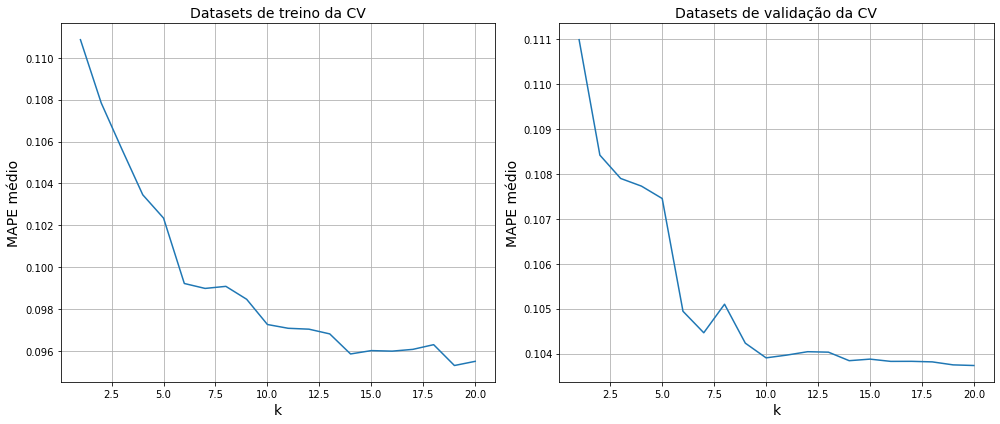

In [49]:
# Visualizando os resultados da seleção de features 

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.lineplot(ax=axes[0], x=range(1, (X_training_scaled_red.shape[1] + 1)), y=score_train_cv_embedded)
axes[0].grid()
axes[0].set_xlabel('k', fontsize=14)
axes[0].set_ylabel(f'MAPE médio', fontsize=14)
axes[0].set_title('Datasets de treino da CV', fontsize=14)

sns.lineplot(ax=axes[1], x=range(1, (X_training_scaled_red.shape[1] + 1)), y=score_val_cv_embedded)
axes[1].grid()
axes[1].set_xlabel('k', fontsize=14)
axes[1].set_ylabel(f'MAPE médio', fontsize=14)
axes[1].set_title('Datasets de validação da CV', fontsize=14)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

In [43]:
# Selecionando as melhores features

selector_embedded = SelectFromModel(estimator=model_embedded, threshold=-np.inf, max_features=10)
selector_embedded.fit(X_training_scaled_red, y_training_red)
retained_features_embedded = X_training_scaled_red.columns[selector_embedded.get_support()]

X_training_scaled_embedded = X_training_scaled_red[retained_features_embedded]
X_test_scaled_embedded = X_test_scaled[retained_features_embedded]

print('---------- EMBEDDED SELECTION ----------')
print()
print('Melhores features: ', retained_features_embedded)

---------- EMBEDDED SELECTION ----------

Melhores features:  Index(['TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU', 'Q001', 'Q002', 'Q003', 'Q004',
       'Q006', 'Q024', 'TP_COR_RACA_Branca', 'TP_ESCOLA_Privada'],
      dtype='object')


## 5.6. Avaliação do modelo final

In [51]:
# Realizando as previsões nos datasets de treino e de teste e calculando a métrica de desempenho

model_bo.fit(X_training_scaled_red[retained_features_embedded], y_training_red)

training_pred = pd.Series(data=model_bo.predict(X_training_scaled[retained_features_embedded]),
                          index=X_training_scaled.index)
test_pred = pd.Series(data=model_bo.predict(X_test_scaled[retained_features_embedded]),
                      index=X_test_scaled.index)

MAPE_training = mean_absolute_percentage_error(y_training, training_pred)
MAPE_test = mean_absolute_percentage_error(y_test, test_pred)

print(f'MAPE no dataset de treino: {round(MAPE_training * 100, 2)} %')
print(f'MAPE no dataset de teste: {round(MAPE_test * 100, 2)} %')

MAPE no dataset de treino: 10.33 %
MAPE no dataset de teste: 10.37 %


In [48]:
# Comparando algumas previsões com os resultados reais

pd.concat([y_test, test_pred], axis=1).rename(columns={'NOTA_GERAL': 'Nota geral real', 0: 'Nota geral prevista'}).reset_index(drop=True).round(2).head(20)

,Nota geral real,Nota geral prevista
0,660.08,563.39
1,493.82,523.52
2,455.26,525.84
3,502.84,476.23
4,438.26,554.09
5,439.76,468.49
6,561.02,481.62
7,744.86,569.55
8,544.10,510.22
9,594.52,619.74
